## Import libraries (XGB3 environment)

In [228]:
from rasterio.transform import from_origin
from rasterio.mask import mask
from rasterio.enums import Resampling
from shapely.geometry import box
from fiona.crs import from_epsg
import geopandas as gpd
import xgboost as xgb
import pandas as pd
import numpy as np
import rasterio
import os
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GridSearchCV, StratifiedKFold, ParameterGrid
from scipy import ndimage
from sklearn.inspection import partial_dependence
import seaborn as sns

import matplotlib.pyplot as plt
from plotnine import *
from scipy import interpolate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import sys
sys.version

import datetime
from dateutil.relativedelta import relativedelta
import os

from math import *

#from Tools import *
#import Tools
exec(open('Tools.py').read())

pd.set_option('display.max_columns',None)

## Create storage directory for fitted models and figures

In [229]:
dr_grid = 50 ## Spatial block size
prefix = 'Fit_all_multigrid1_gamma_new' + str(dr_grid)
model_path = 'Fitted_models/' + prefix + '/'
model_fig_path = 'Fitted_models/' + prefix + '/Figures/'
make_dir(model_path)
make_dir(model_fig_path)

[Errno 17] File exists: 'Fitted_models/Fit_all_multigrid1_gamma_new50/'
[Errno 17] File exists: 'Fitted_models/Fit_all_multigrid1_gamma_new50/Figures/'


## Choose predictors, load and aggregate data 

In [230]:
## Load dataset
All_dat = pd.read_csv('Data/Trap_Data/Clean_Both_Data_By_Trap.csv', low_memory = False)

xmin = All_dat.Longitude.min()
xmax = All_dat.Longitude.max()
ymin = All_dat.Latitude.min()
ymax = All_dat.Latitude.max()
mean_lat = All_dat.Latitude.mean()
dy = dr_grid / 111139


all_agg_data = pd.DataFrame()
np.random.seed(47)
ngrid = 5
for ii in range(ngrid):
    drll = dr_grid/111139
    djx = drll*np.random.random(1)
    djy = drll*np.random.random(1)  
    All_dat.loc[:,'boxi'] = get_grid(All_dat, drll = dy, 
                                djx = djx, djy =djy)[0]
    agg_data = aggregate_data(All_dat, 'boxi', get_var_names() + ['Longitude', 'Latitude'])
    agg_data = agg_data.loc[agg_data.TotTraps > 0,:]
    agg_data.loc[:,'gridi'] = ii
    all_agg_data = pd.concat((all_agg_data, agg_data))

agg_data = all_agg_data

In [231]:
site_means = agg_data.groupby(['Site']).apply(lambda x: x.TS_Mn.mean()).to_frame()
site_means.columns = ['mean_ts']
agg_data = agg_data.merge(site_means, left_on = 'Site', right_index = True)
agg_data.loc[:,'TS_Mn'] = agg_data.loc[:,'TS_Mn'] - agg_data.loc[:,'mean_ts']

## Load models and choose the best for each train-val fold

In [232]:
prefix_list = {'Fit_all_multigrid1_md1_new50':'md1', 
               'Fit_all_multigrid1_gamma_new50':'gamma'}


store_all_models = pd.DataFrame()
for prefix in prefix_list.keys():
    model_path = 'Fitted_models/' + prefix + '/'
    store_summ_df = pd.read_csv(model_path + prefix + '_store_summ.csv')
    store_summ_df.loc[:,'type'] = prefix_list[prefix]
    store_summ_df.loc[:,'prefix'] = prefix
    store_all_models = pd.concat((store_all_models, store_summ_df))
    
    
def f(x):
    if np.sum(x.loc[:,'val_loss'].diff(periods = 2) > 0.00) > 0: 
        best_idx = x.loc[(x.loc[:,'val_loss'].diff(periods = 2) > 0.00) & (x.n_iter > 100), 'n_iter'].idxmin()
    else:
        best_idx = x.loc[:,'val_loss'].idxmin()
    return best_idx
best_summ_niter = store_all_models.groupby(['train_site', 'val_site', 'type','param']).apply(f).to_frame()
best_summ_niter.columns = ['best_index']

mask = store_all_models.index.isin(best_summ_niter.best_index)

best_summ_idx = store_all_models.loc[mask,:].groupby(['train_site', 'val_site']).val_loss.idxmin()
best_models = store_all_models.iloc[best_summ_idx,:]

best_models.to_csv('Figures_agg/' + 'best_models.csv')
best_models.loc[:,['type', 'train_site', 'val_site', 'test_site', 'train_loss', 
                   'sdtrain_loss', 'val_loss', 'sdval_loss', 'test_loss', 'sdtest_loss', 'n_iter', 
                   'max_depth', 'subsample', 'colsample_bytree', 'prec', 'gamma', 'type']]

type train_site  val_site test_site  train_loss  sdtrain_loss  \
25908  gamma    Bafodia    Bantou  Tanganya    0.060862      0.001557   
37068  gamma    Bafodia  Tanganya    Bantou    0.056193      0.001910   
5824     md1     Bantou   Bafodia  Tanganya    0.030210      0.000451   
5413     md1     Bantou  Tanganya   Bafodia    0.021952      0.000173   
3873     md1   Tanganya   Bafodia    Bantou    0.028431      0.000062   
31660  gamma   Tanganya    Bantou   Bafodia    0.021896      0.000086   

       val_loss  sdval_loss  test_loss  sdtest_loss  n_iter  max_depth  \
25908  0.173813    0.000578   0.135758     0.000807     650          4   
37068  0.172051    0.001432   0.197866     0.001463     950          4   
5824   0.109123    0.000688   0.036017     0.000077     700          1   
5413   0.032361    0.000185   0.114400     0.000788    1600          1   
3873   0.108084    0.000780   0.043039     0.000210     650          1   
31660  0.029693    0.000156   0.121341     0.000886    1600          4   

       subsample  colsample_bytree  prec  gamma   type  
25908      0.250               0.2  True    0.1  gamma  
37068      0.250               0.3  True    0.1  gamma  
5824       0.001               0.3  True    0.0    md1  
5413       0.500               0.2  True    0.0    md1  
3873       0.001               0.2  True    0.0    md1  
31660      0.500               0.2  True    2.0  gamma

In [72]:
# prefix_list = {'Fit_all_multigrid1_md1_new50':'md1', 
#                'Fit_all_multigrid1_gamma_new50':'gamma'}
prefix_list = {'Fit_all_scaled_multigrid1_md1_new50':'md1', 
                'Fit_all_scaled_multigrid1_gamma_new50':'gamma'}


store_all_models = pd.DataFrame()
for prefix in prefix_list.keys():
    model_path = 'Fitted_models/' + prefix + '/'
    store_summ_df = pd.read_csv(model_path + prefix + '_store_summ.csv')
    store_summ_df.loc[:,'type'] = prefix_list[prefix]
    store_summ_df.loc[:,'prefix'] = prefix
    store_all_models = pd.concat((store_all_models, store_summ_df))
    
    
def f(x):
    if np.sum(x.loc[:,'val_loss'].diff(periods = 2) > 0.00) > 0: 
        best_idx = x.loc[(x.loc[:,'val_loss'].diff(periods = 2) > 0.00) & (x.n_iter > 100), 'n_iter'].idxmin()
    else:
        best_idx = x.loc[:,'val_loss'].idxmin()
    return best_idx
best_summ_niter = store_all_models.groupby(['train_site', 'val_site', 'type','param']).apply(f).to_frame()
best_summ_niter.columns = ['best_index']

mask = store_all_models.index.isin(best_summ_niter.best_index)

best_summ_idx = store_all_models.loc[mask,:].groupby(['train_site', 'val_site']).val_loss.idxmin()
best_models = store_all_models.iloc[best_summ_idx,:]

best_models.to_csv('Figures_agg/' + 'best_models.csv')
best_models.loc[:,['type', 'train_site', 'val_site', 'test_site', 'train_loss', 
                   'sdtrain_loss', 'val_loss', 'sdval_loss', 'test_loss', 'sdtest_loss', 'n_iter', 
                   'max_depth', 'subsample', 'colsample_bytree', 'prec', 'gamma', 'type']]

type train_site  val_site test_site  train_loss  sdtrain_loss  \
9301   gamma    Bafodia    Bantou  Tanganya    0.059078      0.001797   
5480   gamma    Bafodia  Tanganya    Bantou    0.057173      0.001804   
3268     md1     Bantou   Bafodia  Tanganya    0.016495      0.000079   
34648  gamma     Bantou  Tanganya   Bafodia    0.011583      0.000327   
1558     md1   Tanganya   Bafodia    Bantou    0.016463      0.000055   
28855  gamma   Tanganya    Bantou   Bafodia    0.012849      0.000044   

       val_loss  sdval_loss  test_loss  sdtest_loss  n_iter  max_depth  \
9301   0.037490    0.000243   0.032133     0.000042    1000          4   
5480   0.031501    0.000116   0.036552     0.000145    1050          4   
3268   0.086350    0.000416   0.029141     0.000086    1600          1   
34648  0.028876    0.000085   0.087581     0.000667     850          4   
1558   0.087912    0.000391   0.032784     0.000217    1900          1   
28855  0.028023    0.000244   0.086130     0.000742    1750          4   

       subsample  colsample_bytree  prec  gamma   type  
9301       0.500              0.05  True    2.0  gamma  
5480       0.500              0.05  True    0.5  gamma  
3268       0.100              0.10  True    0.0    md1  
34648      0.050              0.30  True    0.0  gamma  
1558       0.250              0.05  True    0.0    md1  
28855      0.025              0.20  True    1.0  gamma

## Plot gradient descent

In [233]:
best_params = best_models.param.to_list()
base_melt = store_summ_df.melt(id_vars = ['param', 'train_site', 'val_site', 'test_site', 'n_iter'], value_vars = ['train_loss', 'val_loss', 'test_loss'], value_name = 'loss')
best_melt = best_models.merge(base_melt, on = ['param', 'train_site', 'val_site', 'test_site'])
best_melt.loc[:,'group'] = 'tr_' + best_melt.train_site + '_val_' + best_melt.val_site + '_' + best_melt.variable
best_melt.loc[:,'group1'] = 'tr_' + best_melt.train_site + '_val_' + best_melt.val_site 
best_melt.loc[:,'Loss'] = best_melt.variable 

In [234]:
out = (
    ggplot(best_melt, aes(x = 'n_iter_y', y = 'loss', group = 'group', color = 'Loss')) + 
    geom_line() +  
    xlab('n_iter') + ylab('Validation MAE') + ggtitle('MAE') + 
    xlim(0,2000) + ylim(0, 0.3)+ facet_wrap('group1')
)
out.save('Figures_agg/MAE_loss_gamma_ag' + str(dr_grid) + '.png')


/home/andrew/anaconda3/envs/XGB3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/andrew/anaconda3/envs/XGB3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: Figures_agg/MAE_loss_gamma_ag50.png
/home/andrew/anaconda3/envs/XGB3/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/andrew/anaconda3/envs/XGB3/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


/home/andrew/anaconda3/envs/XGB3/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/andrew/anaconda3/envs/XGB3/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


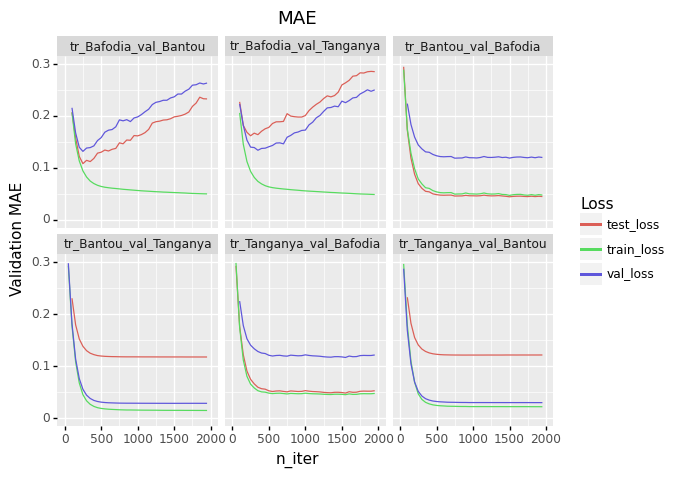

<ggplot: (8754900354597)>

In [235]:
out

## Generate test site predictions with each model

In [236]:
best_models

Unnamed: 0  param train_site  val_site  n_iter  train_loss0  \
25908       25908    332    Bafodia    Bantou     650     0.062057   
37068       37068    475    Bafodia  Tanganya     950     0.058140   
5824         5824     74     Bantou   Bafodia     700     0.029830   
5413         5413     69     Bantou  Tanganya    1600     0.021967   
3873         3873     49   Tanganya   Bafodia     650     0.028438   
31660       31660    405   Tanganya    Bantou    1600     0.021848   

       train_loss1  train_loss2  train_loss3  train_loss4  val_loss0  \
25908     0.059102     0.061429     0.058332     0.058162   0.173145   
37068     0.054321     0.056118     0.053281     0.052867   0.170401   
5824      0.030709     0.030092     0.030691     0.030829   0.108341   
5413      0.022117     0.021772     0.022099     0.022193   0.032574   
3873      0.028490     0.028366     0.028435     0.028293   0.107186   
31660     0.021844     0.021995     0.021889     0.021830   0.029567   

       val_loss1  val_loss2  val_loss3  val_loss4  test_loss0  test_loss1  \
25908   0.174148   0.174145   0.173460   0.174368    0.134859    0.135994   
37068   0.172778   0.172974   0.171736   0.173228    0.196244    0.199088   
5824    0.109391   0.109637   0.108617   0.107843    0.035969    0.035977   
5413    0.032269   0.032240   0.032170   0.032460    0.113502    0.114724   
3873    0.108601   0.108465   0.107504   0.106948    0.042798    0.043177   
31660   0.029867   0.029644   0.029854   0.029887    0.120348    0.121629   

       test_loss2  test_loss3  test_loss4 booster  colsample_bytree  dr   eta  \
25908    0.136420    0.136158    0.136455  gbtree               0.2   0  0.01   
37068    0.198266    0.198439    0.198655  gbtree               0.3   0  0.01   
5824     0.036106    0.036225    0.035872  gbtree               0.3   0  0.01   
5413     0.114975    0.113613    0.113499  gbtree               0.2   0  0.01   
3873     0.043143    0.043004    0.043156  gbtree               0.2   0  0.01   
31660    0.122048    0.120327    0.120194  gbtree               0.2   0  0.01   

      eval_metric  gamma  lambda  max_depth  n_estimators  nthread  prec  \
25908        rmse    0.1       0          4          2000        2  True   
37068        rmse    0.1       0          4          2000        2  True   
5824         rmse    0.0       0          1          2000        2  True   
5413         rmse    0.0       0          1          2000        2  True   
3873         rmse    0.0       0          1          2000        2  True   
31660        rmse    2.0       0          4          2000        2  True   

       subsample test_site  train_loss  sdtrain_loss  val_loss  sdval_loss  \
25908      0.250  Tanganya    0.060862      0.001557  0.173813    0.000578   
37068      0.250    Bantou    0.056193      0.001910  0.172051    0.001432   
5824       0.001  Tanganya    0.030210      0.000451  0.109123    0.000688   
5413       0.500   Bafodia    0.021952      0.000173  0.032361    0.000185   
3873       0.001    Bantou    0.028431      0.000062  0.108084    0.000780   
31660      0.500   Bafodia    0.021896      0.000086  0.029693    0.000156   

       test_loss  sdtest_loss   type                                 prefix  
25908   0.135758     0.000807  gamma  Fit_all_scaled_multigrid1_gamma_new50  
37068   0.197866     0.001463  gamma  Fit_all_scaled_multigrid1_gamma_new50  
5824    0.036017     0.000077    md1    Fit_all_scaled_multigrid1_md1_new50  
5413    0.114400     0.000788    md1    Fit_all_scaled_multigrid1_md1_new50  
3873    0.043039     0.000210    md1    Fit_all_scaled_multigrid1_md1_new50  
31660   0.121341     0.000886  gamma  Fit_all_scaled_multigrid1_gamma_new50

In [239]:
exec(open('Tools.py').read())

njiggles = 25
house_set = [0,1,2] #which traps:  0 ~ all, 1~ just house, 2~just outside
water_preds = [x for x in get_var_names() if 'water' in x]
#rem_preds = ['P' + str(x) for x in np.arange(1,13)] + ['Night'] + ['House'] + water_preds
#rem_preds = ['P' + str(x) for x in np.arange(1,13)] + ['Night'] 
rem_preds = ['Night']
#rem_preds = []
test_list = ['Tanganya', 'Bantou', 'Bafodia']
pre = '_base_all_earlystopping100_whouse_wprec'



#pred_vs_true = pd.DataFrame()
store_all_stats = pd.DataFrame()


for ii in range(len(test_list)):

    test_site = test_list[ii]
    
    for house_num in house_set:
        house_list = [0,1]
        if house_num == 1:
            house_list = [1]
        elif house_num==2:
            house_list = [0]

        all_stats = pd.DataFrame()

        for ji in range(njiggles):

            ## Assign grid ID's to data
            mask_data = ((All_dat.Site==test_site) & 
                         (All_dat.House.isin(house_list)))

            test_dat = All_dat.loc[mask_data,:].copy()                

            ## -- Box data into grid
            drll = dr_grid/111139
            djx = drll*np.random.random(1)
            djy = drll*np.random.random(1)
            test_dat.loc[:,'boxi'] = get_grid(test_dat, drll, djx, djy)[0]

            # aggregate test_dat over house, site, foldID
            agg_test_dat = aggregate_data(test_dat, 'boxi', get_var_names())

            # remove entries with no traps
            agg_test_dat = agg_test_dat.loc[agg_test_dat.TotTraps > 0,:]

            for model_type in ['NullSmart', 'NullRandom', 'Model','TS']:
                summ_stats = agg_test_dat.copy()

                ## Apply model
                if model_type == 'NullRandom':
                    result = np.random.rand(summ_stats.shape[0])
                elif model_type =='NullSmart':
                    result = summ_stats.loc[:,'Density_Buildings.100'].copy()
                elif model_type == 'Model':
                    result_list = []
                    wi_row = best_models.test_site==test_site
                    best_rows = best_models.loc[wi_row,:]
                    ## Verify that there are two best models for this test site
                    if best_rows.shape[0] != 2:
                        print('ERROR1')
                    ## Loop through and apply models
                    for idx in best_rows.index:
                        param_i = best_rows.param.loc[idx]
                        n_iter = int(best_rows.n_iter.loc[idx])
                        val_site = best_rows.val_site.loc[idx]
                        focal_model = xgb.XGBRegressor(objective = 'reg:logistic')
                        this_model_path = 'Fitted_models/' + best_rows.prefix.loc[idx] + '/'
                        focal_model.load_model(this_model_path + 'par_' + str(param_i) + '_fold_' + str(val_site) + '.txt')

                        test_dat_cp = agg_test_dat.loc[:,get_var_names(prec_flag = best_rows.loc[idx,'prec'])].copy()

                        rem_preds = [x for x in rem_preds if x in test_dat_cp.columns]
                        test_dat_cp.loc[:,rem_preds] = np.nan
                        result = focal_model.predict(test_dat_cp, iteration_range = (0,n_iter))
                        result = result[:,np.newaxis]
                        result_list.append(result)
                    #result = np.concatenate(result_list, axis = 1).mean(axis = 1)

                elif model_type == 'TS':
                    result = agg_test_dat.TS_Mn.values
                else:
                    print('ERROR2')
                
                if model_type=='Model':  
                    all_models = pd.DataFrame()
                    for ii in [0,1]:
                        result = result_list[ii]
                        summ_stats.loc[:,'pred'] = result
                        summ_stats.loc[:,'train_site'] = best_rows.iloc[ii,:].train_site
                        summ_stats.loc[:,'val_site'] = best_rows.iloc[ii,:].val_site                        
                        all_models = pd.concat((all_models, summ_stats), axis = 0)
                    summ_stats = all_models
                else:
                    summ_stats.loc[:,'pred'] = result                    

                summ_stats.loc[:,'dr'] = dr_grid                  
                summ_stats.loc[:,'house_num'] = house_num
                summ_stats.loc[:,'test_site'] = test_site                   
                summ_stats.loc[:,'Model_Type'] = model_type
                summ_stats.loc[:,'ji'] = str(ji)
                summ_stats.reset_index(drop = False, inplace = True)

                all_stats = pd.concat((all_stats, summ_stats), ignore_index = True)

        store_all_stats = pd.concat((store_all_stats, all_stats), ignore_index = True)
store_all_stats.to_csv('Figures_agg/' + 'rank_curves' + pre + '.csv')

## Same as above but loop through visits

In [240]:
exec(open('Tools.py').read())

njiggles = 25
house_set = [0,1,2] #which traps:  0 ~ all, 1~ just house, 2~just outside
rem_preds = []##['P' + str(x) for x in np.arange(1,13)]#['Night'] + ['P' + str(x) for x in np.arange(1,13)]# + ['House']
test_list = ['Tanganya', 'Bantou', 'Bafodia']
pre = ''

#pred_vs_true = pd.DataFrame()
store_all_stats = pd.DataFrame()

for ii in range(len(test_list)):

    test_site = test_list[ii]
    visit_set = All_dat.loc[All_dat.Site.isin([test_site]),'Visit'].unique().tolist() 
    
    print(test_site)
    
    for visiti in visit_set:
    
        for house_num in house_set:
            house_list = [0,1]
            if house_num == 1:
                house_list = [1]
            elif house_num==2:
                house_list = [0]

            all_stats = pd.DataFrame()

            for ji in range(njiggles):

                ## Assign grid ID's to data
                mask_data = ((All_dat.Site==test_site) & 
                             (All_dat.House.isin(house_list)) & 
                            (All_dat.Visit.isin([visiti])))

                test_dat = All_dat.loc[mask_data,:].copy()                

                if test_dat.shape[0] > 0:
                
                    ## -- Box data into grid
                    drll = dr_grid/111139
                    djx = drll*np.random.random(1)
                    djy = drll*np.random.random(1)
                    test_dat.loc[:,'boxi'] = get_grid(test_dat, drll, djx, djy)[0]

                    # aggregate test_dat over house, site, foldID
                    agg_test_dat = aggregate_data(test_dat, 'boxi', get_var_names())

                    # remove entries with no traps
                    agg_test_dat = agg_test_dat.loc[agg_test_dat.TotTraps > 0,:]

                    for model_type in ['NullSmart', 'NullRandom', 'Model','TS']:
                        summ_stats = agg_test_dat.copy()

                        ## Apply model
                        if model_type == 'NullRandom':
                            result = np.random.rand(summ_stats.shape[0])
                        elif model_type =='NullSmart':
                            result = summ_stats.loc[:,'Density_Buildings.100'].copy()
                        elif model_type == 'Model':
                            result_list = []
                            wi_row = best_models.test_site==test_site
                            best_rows = best_models.loc[wi_row,:]
                            ## Verify that there are two best models for this test site
                            if best_rows.shape[0] != 2:
                                print('ERROR1')
                            ## Loop through and apply models
                            for idx in best_rows.index:
                                param_i = best_rows.param.loc[idx]
                                n_iter = int(best_rows.n_iter.loc[idx])
                                val_site = best_rows.val_site.loc[idx]
                                focal_model = xgb.XGBRegressor(objective = 'reg:logistic')
                                this_model_path = 'Fitted_models/' + best_rows.prefix.loc[idx] + '/'
                                focal_model.load_model(this_model_path + 'par_' + str(param_i) + '_fold_' + str(val_site) + '.txt')

                                test_dat_cp = agg_test_dat.loc[:,get_var_names(prec_flag = best_rows.loc[idx,'prec'])].copy()

                                rem_preds = [x for x in rem_preds if x in test_dat_cp.columns]
                                test_dat_cp.loc[:,rem_preds] = np.nan
                                result = focal_model.predict(test_dat_cp, iteration_range = (0,n_iter))
                                result = result[:,np.newaxis]
                                result_list.append(result)
                            result = np.concatenate(result_list, axis = 1).mean(axis = 1)

                        elif model_type == 'TS':
                            result = agg_test_dat.TS_Mn.values
                        else:
                            print('ERROR2')

                        summ_stats.loc[:,'pred'] = result
                        summ_stats.loc[:,'house_num'] = house_num
                        summ_stats.reset_index(drop = False, inplace = True)

                        summ_stats.loc[:,'Model_Type'] = model_type
                        summ_stats.loc[:,'ji'] = str(ji)

                        summ_stats.loc[:,'visit'] = visiti
                        summ_stats = summ_stats.sort_values('pred', ascending = False)

                        ## Add in dummy row for 0,0
                        dummy_row = pd.DataFrame(summ_stats.iloc[0:1,:].copy())
                        dummy_row.loc[:,'Tot_Mn'] = 0
                        dummy_row.loc[:,'TotTraps'] = 0
                        dummy_row.loc[:,'pred'] = 10
                        dummy_row.loc[:,'foldID'] = np.nan
                        summ_stats = pd.concat((dummy_row,
                                   summ_stats), axis = 0, ignore_index = True)

                        summ_stats.loc[:,'cumulative'] = summ_stats.Tot_Mn.astype(float).cumsum() 
                        summ_stats.loc[:,'rank'] = range(summ_stats.shape[0])
                        summ_stats.loc[:,'cTotTraps'] = summ_stats.TotTraps.astype(float).cumsum()
                        summ_stats.loc[:,'cTotCaptures'] = summ_stats.Tot_Mn.astype(float).cumsum()
                        summ_stats.loc[:,'dr'] = dr_grid
                        summ_stats.loc[:,'house_num'] = house_num
                        summ_stats.loc[:,'test_site'] = test_site

                        all_stats = pd.concat((all_stats, summ_stats), ignore_index = True)

            store_all_stats = pd.concat((store_all_stats, all_stats), ignore_index = True)
store_all_stats.to_csv('Figures_agg/' + 'rank_curves_by_visit' + pre + '.csv')

Tanganya
Bantou
Bafodia


## Create variable importance plots

In [241]:
store_all_imp = pd.DataFrame()

fold_list = list(itertools.permutations(['Tanganya', 'Bantou', 'Bafodia']))
for ii in range(len(fold_list)):
    store_var_imp = pd.DataFrame()

    train_site, val_site, test_site = fold_list[ii]

    X_trainval, y_trainval, W_trainval, trainval_dat, test_dat = get_trainval_data(dataset = agg_data, 
                                                                         test_sites = [test_site], 
                                                                        response = 'TS_Mn', 
                                                                        weight = 'TotTraps')     
    
    train_xvals = trainval_dat.loc[trainval_dat.Site.isin([train_site]), get_var_names()]
    
    mask_model = (best_models.loc[:,'test_site'].isin([test_site]) & 
                  best_models.loc[:,'val_site'].isin([val_site])) 

    param_i = best_models.loc[mask_model, 'param'].values[0]
    xgb_model = xgb.XGBRegressor(objective = 'binary:logistic')
    this_model_path = 'Fitted_models/' + best_models.prefix.loc[mask_model].values[0] + '/'
    xgb_model.load_model(this_model_path + 'par_' + str(param_i) + '_fold_' + str(val_site) + '.txt')
    feature_names = get_var_names()

    nfeat = len(feature_names)
    feature_arg = xgb_model.feature_importances_.argsort()
    importances = xgb_model.feature_importances_[feature_arg][:,np.newaxis]
    names = np.array([feature_names[x] for x in feature_arg])[:,np.newaxis]
    
    store_var_imp = pd.DataFrame(np.concatenate((names, importances), axis = 1))
    store_var_imp.columns = ['Variable','imp']
    store_var_imp.loc[:,'prefix'] = best_models.prefix.loc[mask_model].values[0]
    store_var_imp.loc[:,'train_site'] = train_site
    store_var_imp.loc[:,'val_site'] = val_site
    store_var_imp.loc[:,'test_site'] = test_site
    
    store_all_imp = pd.concat((store_all_imp, store_var_imp ), axis = 0)   


store_all_imp.loc[:,'imp'] = store_all_imp.loc[:,'imp'].astype(float)
pivot_all_imp = pd.pivot(store_all_imp, index=['Variable'], columns=['train_site','val_site','test_site'], values=['imp'])
pivot_all_imp.loc[:,'Mean'] = pivot_all_imp.mean(axis = 1)
pivot_all_imp.columns = [('Tanganya', 'Bantou'), ('Tanganya', 'Bafodia'),
                        ('Bantou', 'Tanganya'), ('Bantou', 'Bafodia'),
                         ('Bafodia', 'Tanganya'), ('Bafodia', 'Bantou'),
                        'Mean']

In [242]:
ag_features = get_features(rvec = [25,50,100,200,500,1000], names = ['Frac_rice', 'Frac_mound'])
basic_lc_features = get_features(rvec = [25,50,100,200,500,1000], names = ['Frac_bare', 'Frac_tree', 'Frac_burn', 'Frac_grass', 'Frac_water'])
lc_features = ag_features + basic_lc_features
build_features = get_features(rvec = [25,50,100,200,500,1000], names = ['Density_Buildings', 'sc_Density_Buildings', 'Density_Moderns', 'sc_Density_Moderns', 'Density_Traditionals', 'sc_Density_Traditionals'])
build_features = build_features #+ ['Night'] + ['House']
prec_features = ['P' + str(x) for x in np.arange(1,13)]
all_features = build_features + lc_features + prec_features
night_features = ['Night']
house_features = ['House']
all_features = build_features + lc_features + prec_features + house_features + night_features

In [243]:
pivot_all_imp

(Tanganya, Bantou)  (Tanganya, Bafodia)  \
Variable                                                                
Density_Buildings.100                   0.013263             0.037305   
Density_Buildings.1000                  0.000000             0.008614   
Density_Buildings.200                   0.000000             0.025827   
Density_Buildings.25                    0.041747             0.012338   
Density_Buildings.50                    0.038825             0.010543   
...                                          ...                  ...   
sc_Density_Traditionals.1000            0.000000             0.011613   
sc_Density_Traditionals.200             0.012777             0.000000   
sc_Density_Traditionals.25              0.091359             0.000000   
sc_Density_Traditionals.50              0.040250             0.000000   
sc_Density_Traditionals.500             0.000000             0.000000   

                              (Bantou, Tanganya)  (Bantou, Bafodia)  \
Variable                                                              
Density_Buildings.100                   0.070988           0.022322   
Density_Buildings.1000                  0.001137           0.077826   
Density_Buildings.200                   0.009126           0.008342   
Density_Buildings.25                    0.005608           0.046979   
Density_Buildings.50                    0.055630           0.197060   
...                                          ...                ...   
sc_Density_Traditionals.1000            0.000000           0.000000   
sc_Density_Traditionals.200             0.007052           0.000000   
sc_Density_Traditionals.25              0.006414           0.000000   
sc_Density_Traditionals.50              0.015424           0.000000   
sc_Density_Traditionals.500             0.002887           0.000000   

                              (Bafodia, Tanganya)  (Bafodia, Bantou)      Mean  
Variable                                                                        
Density_Buildings.100                    0.012628           0.009792  0.027716  
Density_Buildings.1000                   0.009592           0.010258  0.017904  
Density_Buildings.200                    0.010257           0.010612  0.010694  
Density_Buildings.25                     0.011300           0.012305  0.021713  
Density_Buildings.50                     0.010528           0.009851  0.053740  
...                                           ...                ...       ...  
sc_Density_Traditionals.1000             0.008764           0.011687  0.005344  
sc_Density_Traditionals.200              0.009145           0.010960  0.006656  
sc_Density_Traditionals.25               0.011482           0.011290  0.020091  
sc_Density_Traditionals.50               0.006818           0.009158  0.011942  
sc_Density_Traditionals.500              0.010799           0.010525  0.004035  

[92 rows x 7 columns]

### Heatmap of overall importance for different variable sets

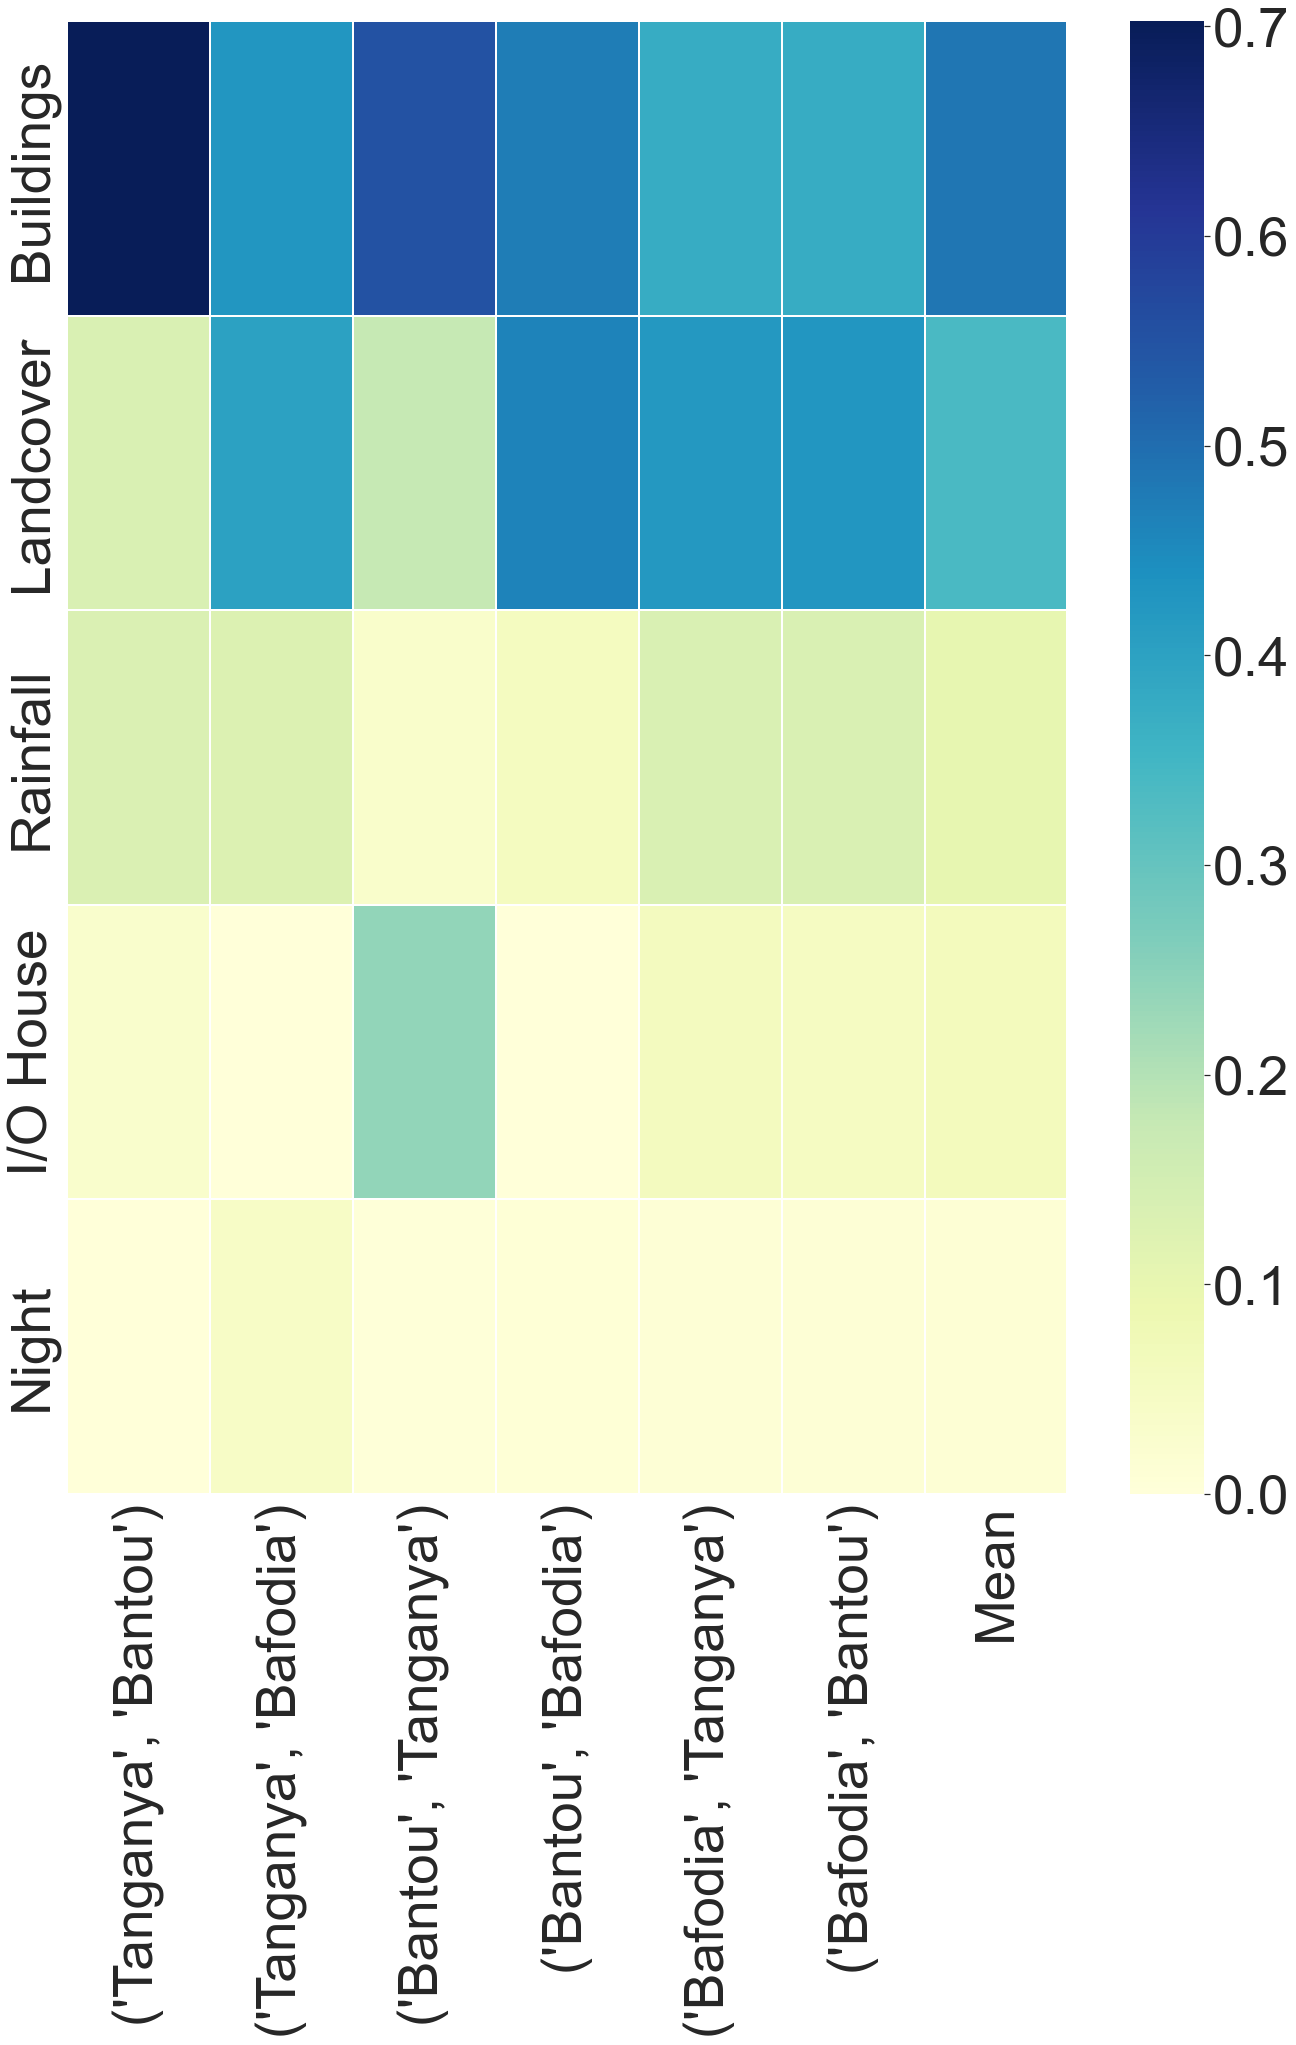

In [244]:
pdat = pivot_all_imp.copy()
pdat = pdat.apply(lambda x: x/x.sum())

plot_dat = pd.DataFrame()

feature_dict = {'Buildings': build_features, 'Landcover':lc_features, 'Rainfall': prec_features,
               'I/O House':house_features, 'Night':night_features}

## Compute sums of predictor importance over variable types
for feature_i in feature_dict.keys():    
    focal_features = feature_dict[feature_i]
    agg_pdat = pdat.loc[focal_features,:].sum(axis = 0).to_frame()
    agg_pdat.columns = [feature_i]
    plot_dat = pd.concat((plot_dat, agg_pdat), axis = 1)

plot_dat.loc[:,plot_dat.columns!='Mean'].mean(axis = 1)

fig, ax = plt.subplots(figsize=(20,30))

sns.set(font_scale=5)

sns.heatmap(plot_dat.transpose(), cmap ='YlGnBu', linewidths = 0.30, annot = False, ax = ax, 
        vmin = 0)
plt.tight_layout()

plt.savefig('Figures_agg/heatmap_imp.png')

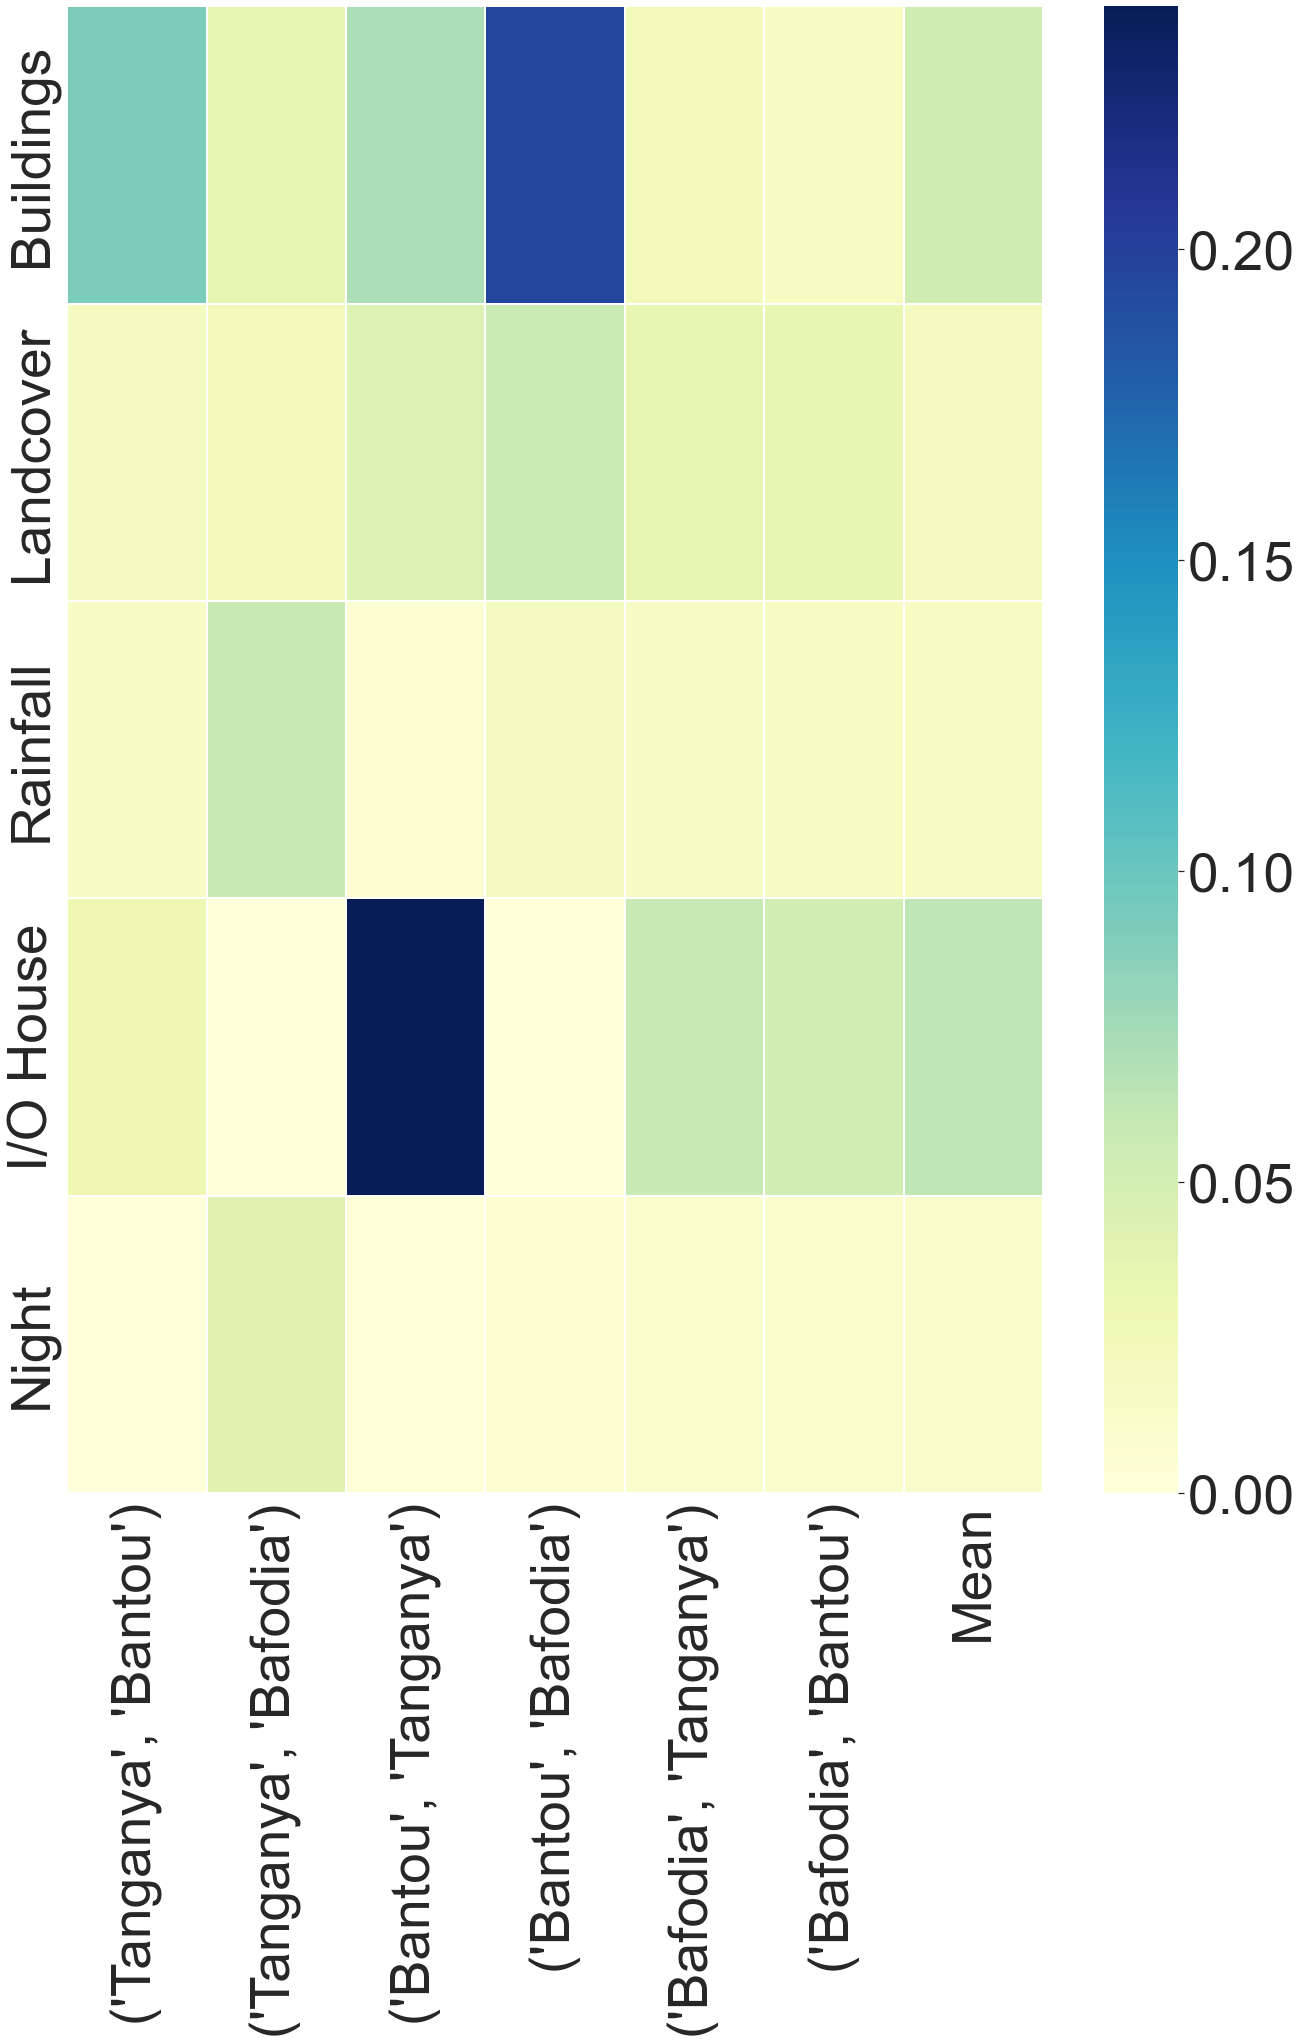

In [245]:
pdat = pivot_all_imp.copy()
pdat = pdat.apply(lambda x: x/x.sum())

plot_dat = pd.DataFrame()

feature_dict = {'Buildings': build_features, 'Landcover':lc_features, 'Rainfall': prec_features,
               'I/O House':house_features, 'Night':night_features}

## Compute sums of predictor importance over variable types
for feature_i in feature_dict.keys():    
    focal_features = feature_dict[feature_i]
    agg_pdat = pdat.loc[focal_features,:].max(axis = 0).to_frame()
    agg_pdat.columns = [feature_i]
    plot_dat = pd.concat((plot_dat, agg_pdat), axis = 1)

plot_dat.loc[:,plot_dat.columns!='Mean'].mean(axis = 1)

fig, ax = plt.subplots(figsize=(20,30))

sns.set(font_scale=5)

sns.heatmap(plot_dat.transpose(), cmap ='YlGnBu', linewidths = 0.30, annot = False, ax = ax, 
        vmin = 0)
plt.tight_layout()

plt.savefig('Figures_agg/heatmap_imp_max.png')

### Break down by building type

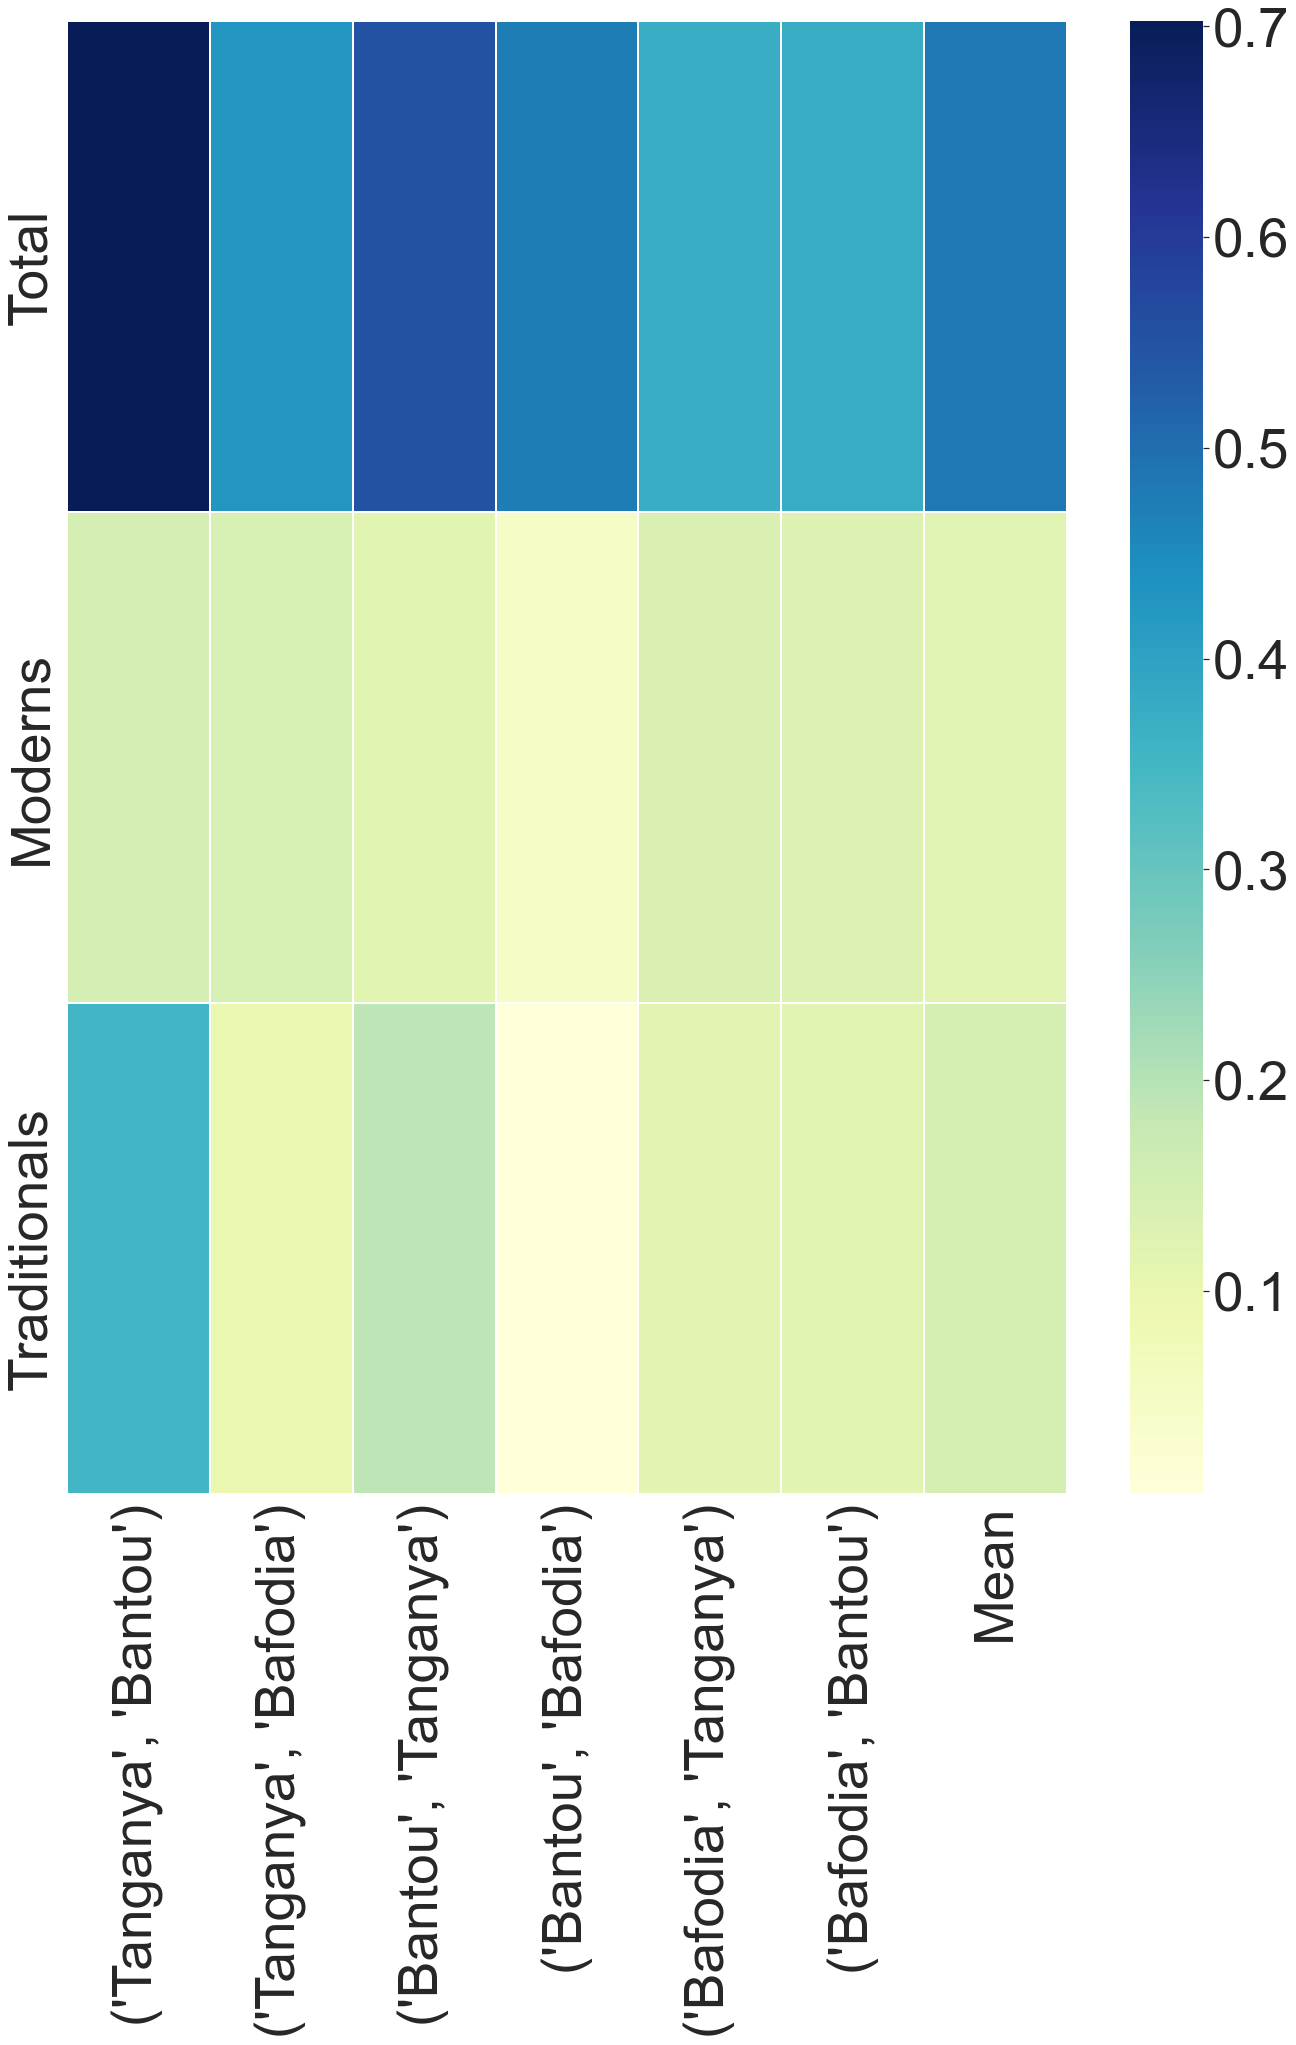

In [246]:
feature_dict = {'Total':build_features, 'Moderns': build_mod_features, 'Traditionals':build_trad_features}
plot_dat = pd.DataFrame()
for feature_i in feature_dict.keys():    
    focal_features = feature_dict[feature_i]
    agg_pdat = pdat.loc[focal_features,:].sum(axis = 0).to_frame()
    agg_pdat.columns = [feature_i]
    plot_dat = pd.concat((plot_dat, agg_pdat), axis = 1)

plot_dat.loc[:,plot_dat.columns!='Mean'].mean(axis = 1)
fig, ax = plt.subplots(figsize=(20,30))

sns.set(font_scale=5)

sns.heatmap(plot_dat.transpose(), cmap ='YlGnBu', linewidths = 0.30, annot = False, ax = ax)
plt.tight_layout()

plt.savefig('Figures_agg/heatmap_imp_build.png')

### Break down by LC type

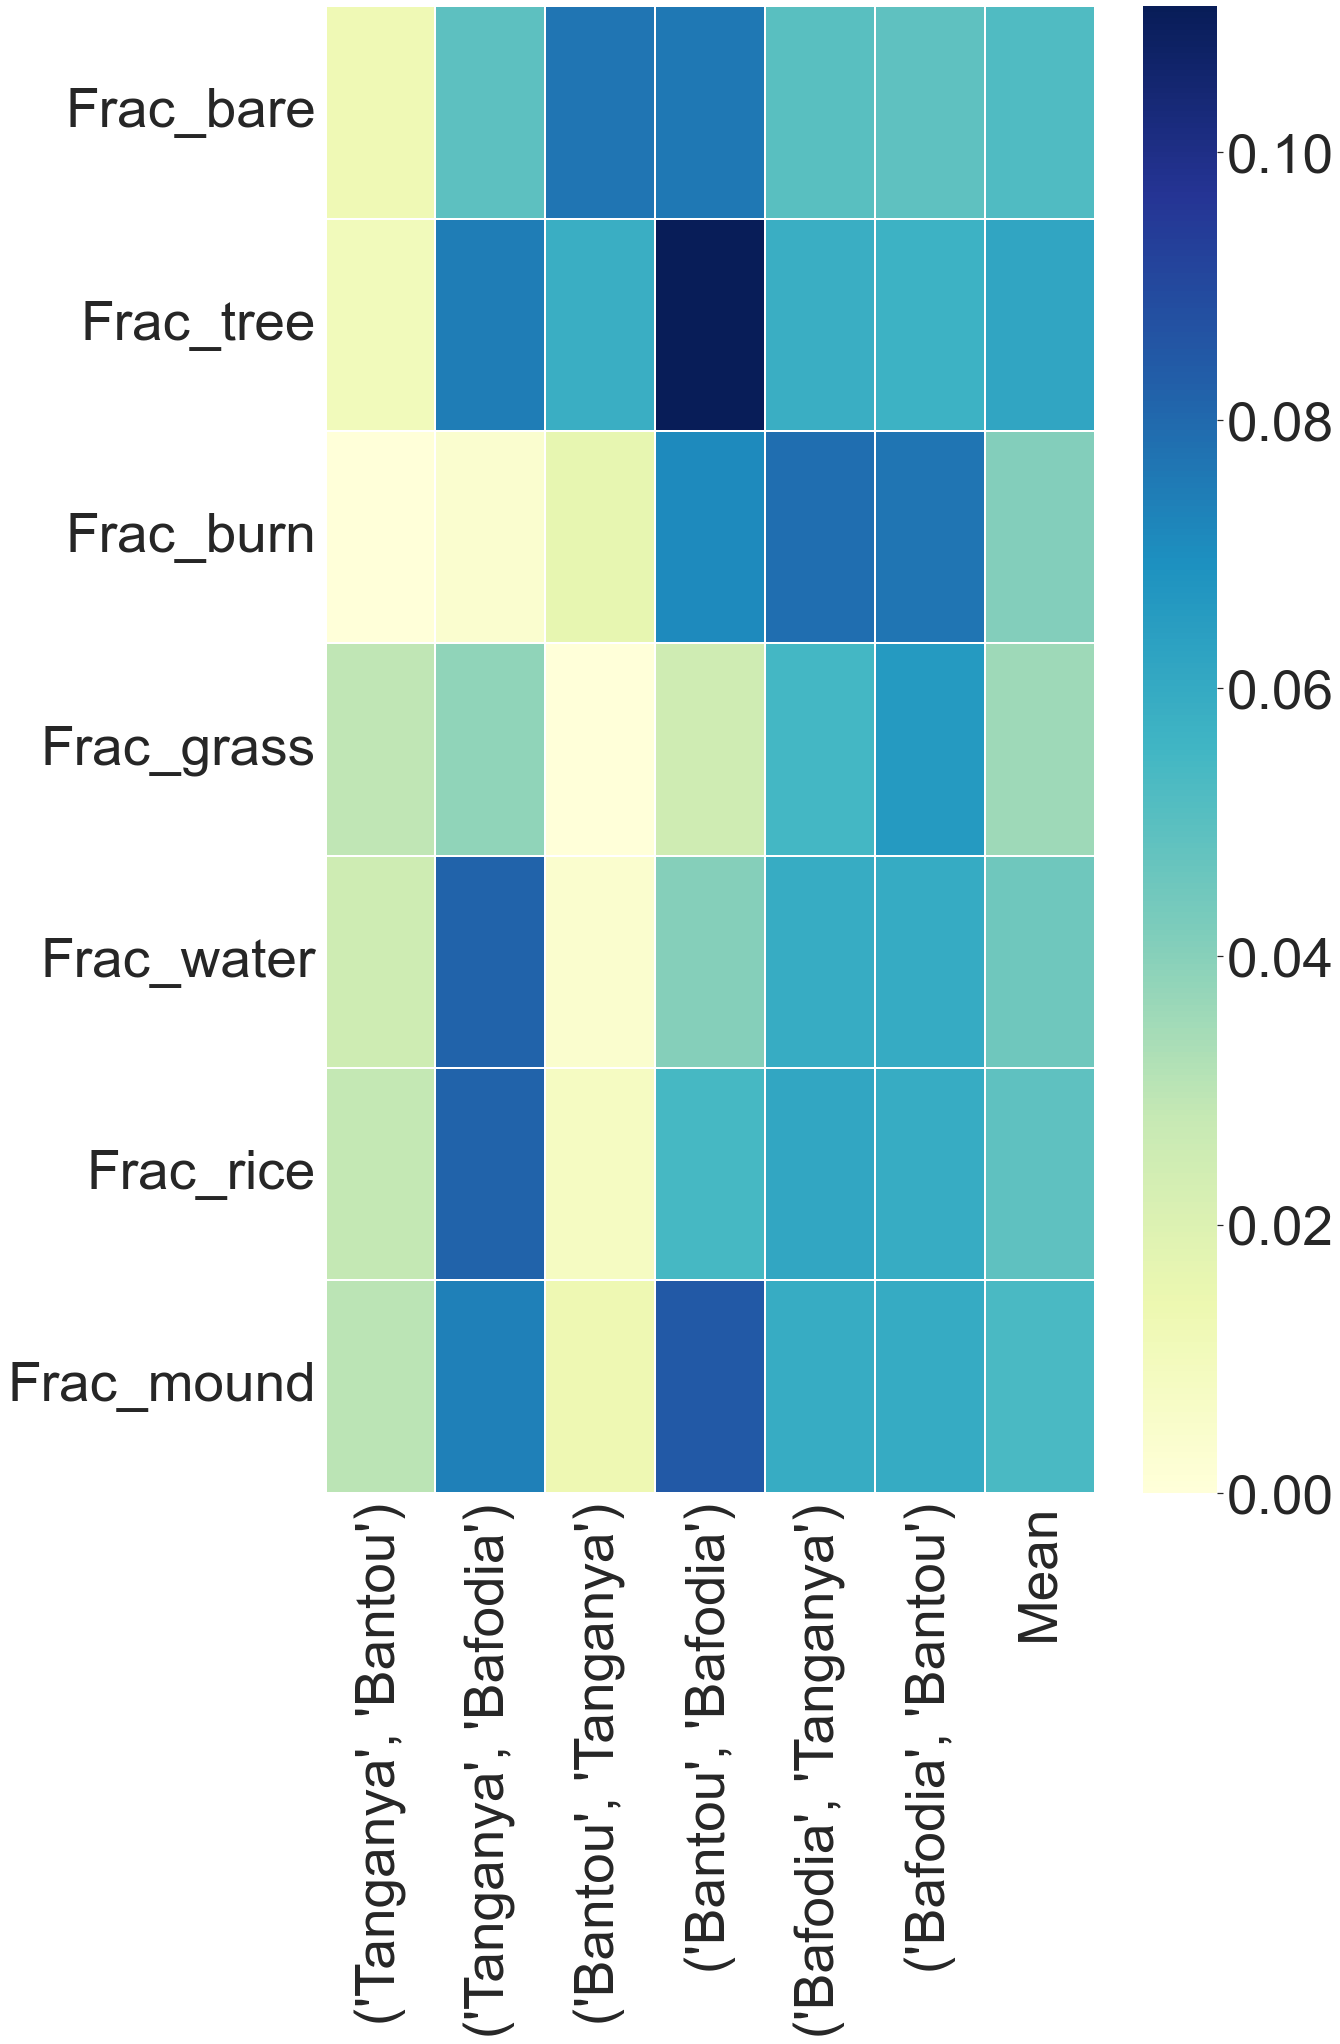

In [247]:
feature_dict = {}
for name in ['Frac_bare', 'Frac_tree', 'Frac_burn', 'Frac_grass', 'Frac_water', 'Frac_rice', 'Frac_mound']:
    feature_set = get_features(rvec = [25,50,100,200,500,1000], names = [name])
    feature_dict[name] = feature_set

plot_dat = pd.DataFrame()
for feature_i in feature_dict.keys():    
    focal_features = feature_dict[feature_i]
    agg_pdat = pdat.loc[focal_features,:].sum(axis = 0).to_frame()
    agg_pdat.columns = [feature_i]
    plot_dat = pd.concat((plot_dat, agg_pdat), axis = 1)

plot_dat.loc[:,plot_dat.columns!='Mean'].mean(axis = 1)
fig, ax = plt.subplots(figsize=(20,30))

sns.set(font_scale=5)

sns.heatmap(plot_dat.transpose(), cmap ='YlGnBu', linewidths = 0.30, annot = False, ax = ax)
plt.tight_layout()

plt.savefig('Figures_agg/heatmap_imp_lc.png')

### Building features at different radii

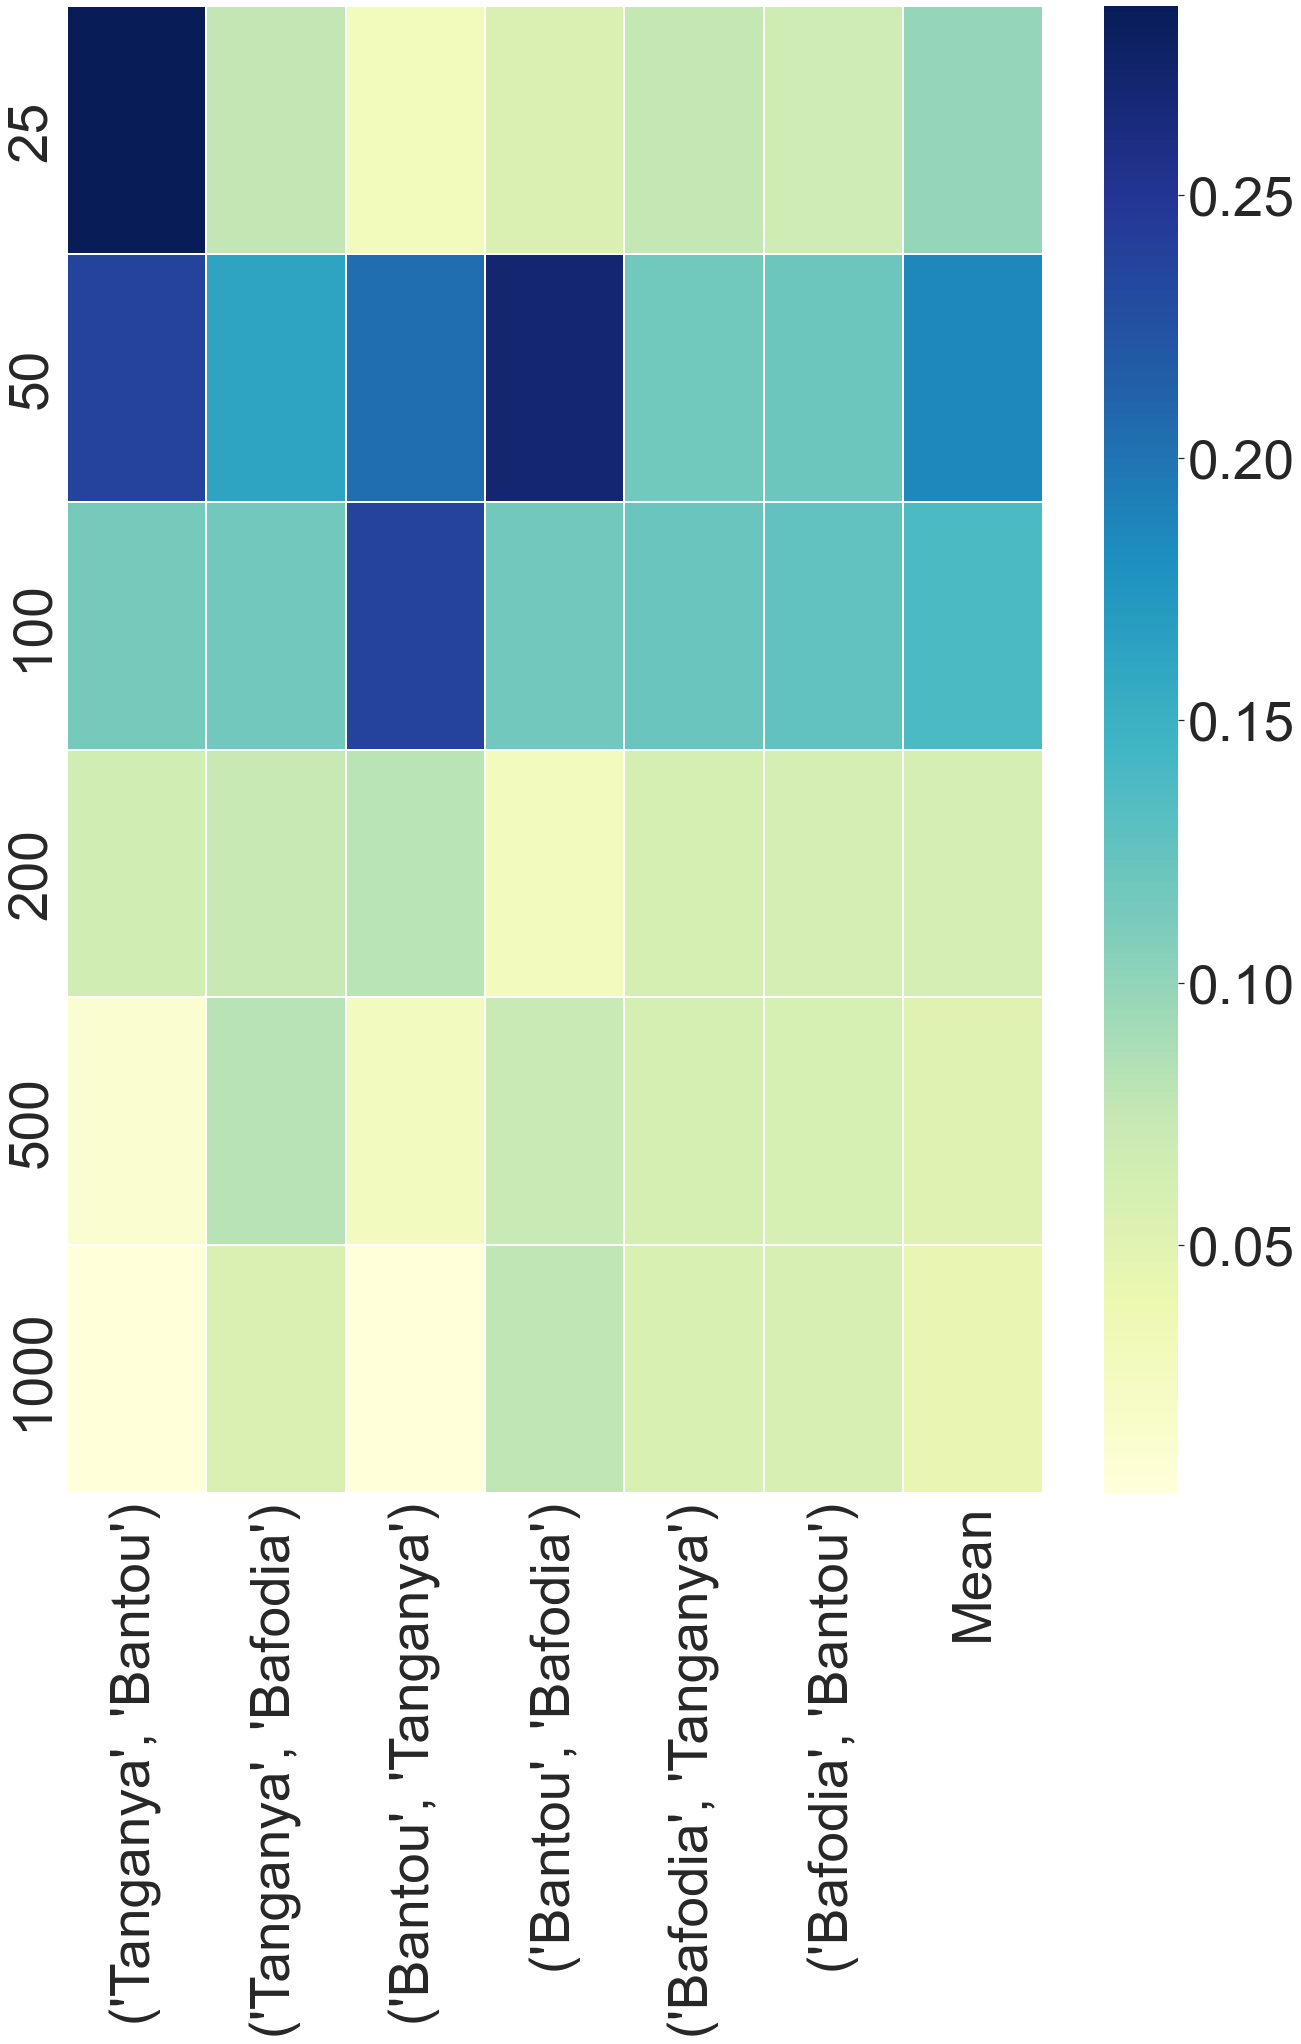

In [248]:
feature_dict = {}
for radius in [25,50,100,200,500,1000]:
    feature_set = [x for x in build_features if str(radius) in x]
    feature_dict[str(radius)] = feature_set

plot_dat = pd.DataFrame()
for feature_i in feature_dict.keys():    
    focal_features = feature_dict[feature_i]
    agg_pdat = pdat.loc[focal_features,:].sum(axis = 0).to_frame()
    agg_pdat.columns = [feature_i]
    plot_dat = pd.concat((plot_dat, agg_pdat), axis = 1)

plot_dat.loc[:,plot_dat.columns!='Mean'].mean(axis = 1)
fig, ax = plt.subplots(figsize=(20,30))

sns.set(font_scale=5)

sns.heatmap(plot_dat.transpose(), cmap ='YlGnBu', linewidths = 0.30, annot = False, ax = ax)
plt.tight_layout()

plt.savefig('Figures_agg/heatmap_build_radius.png')

### Landcover features at different radii

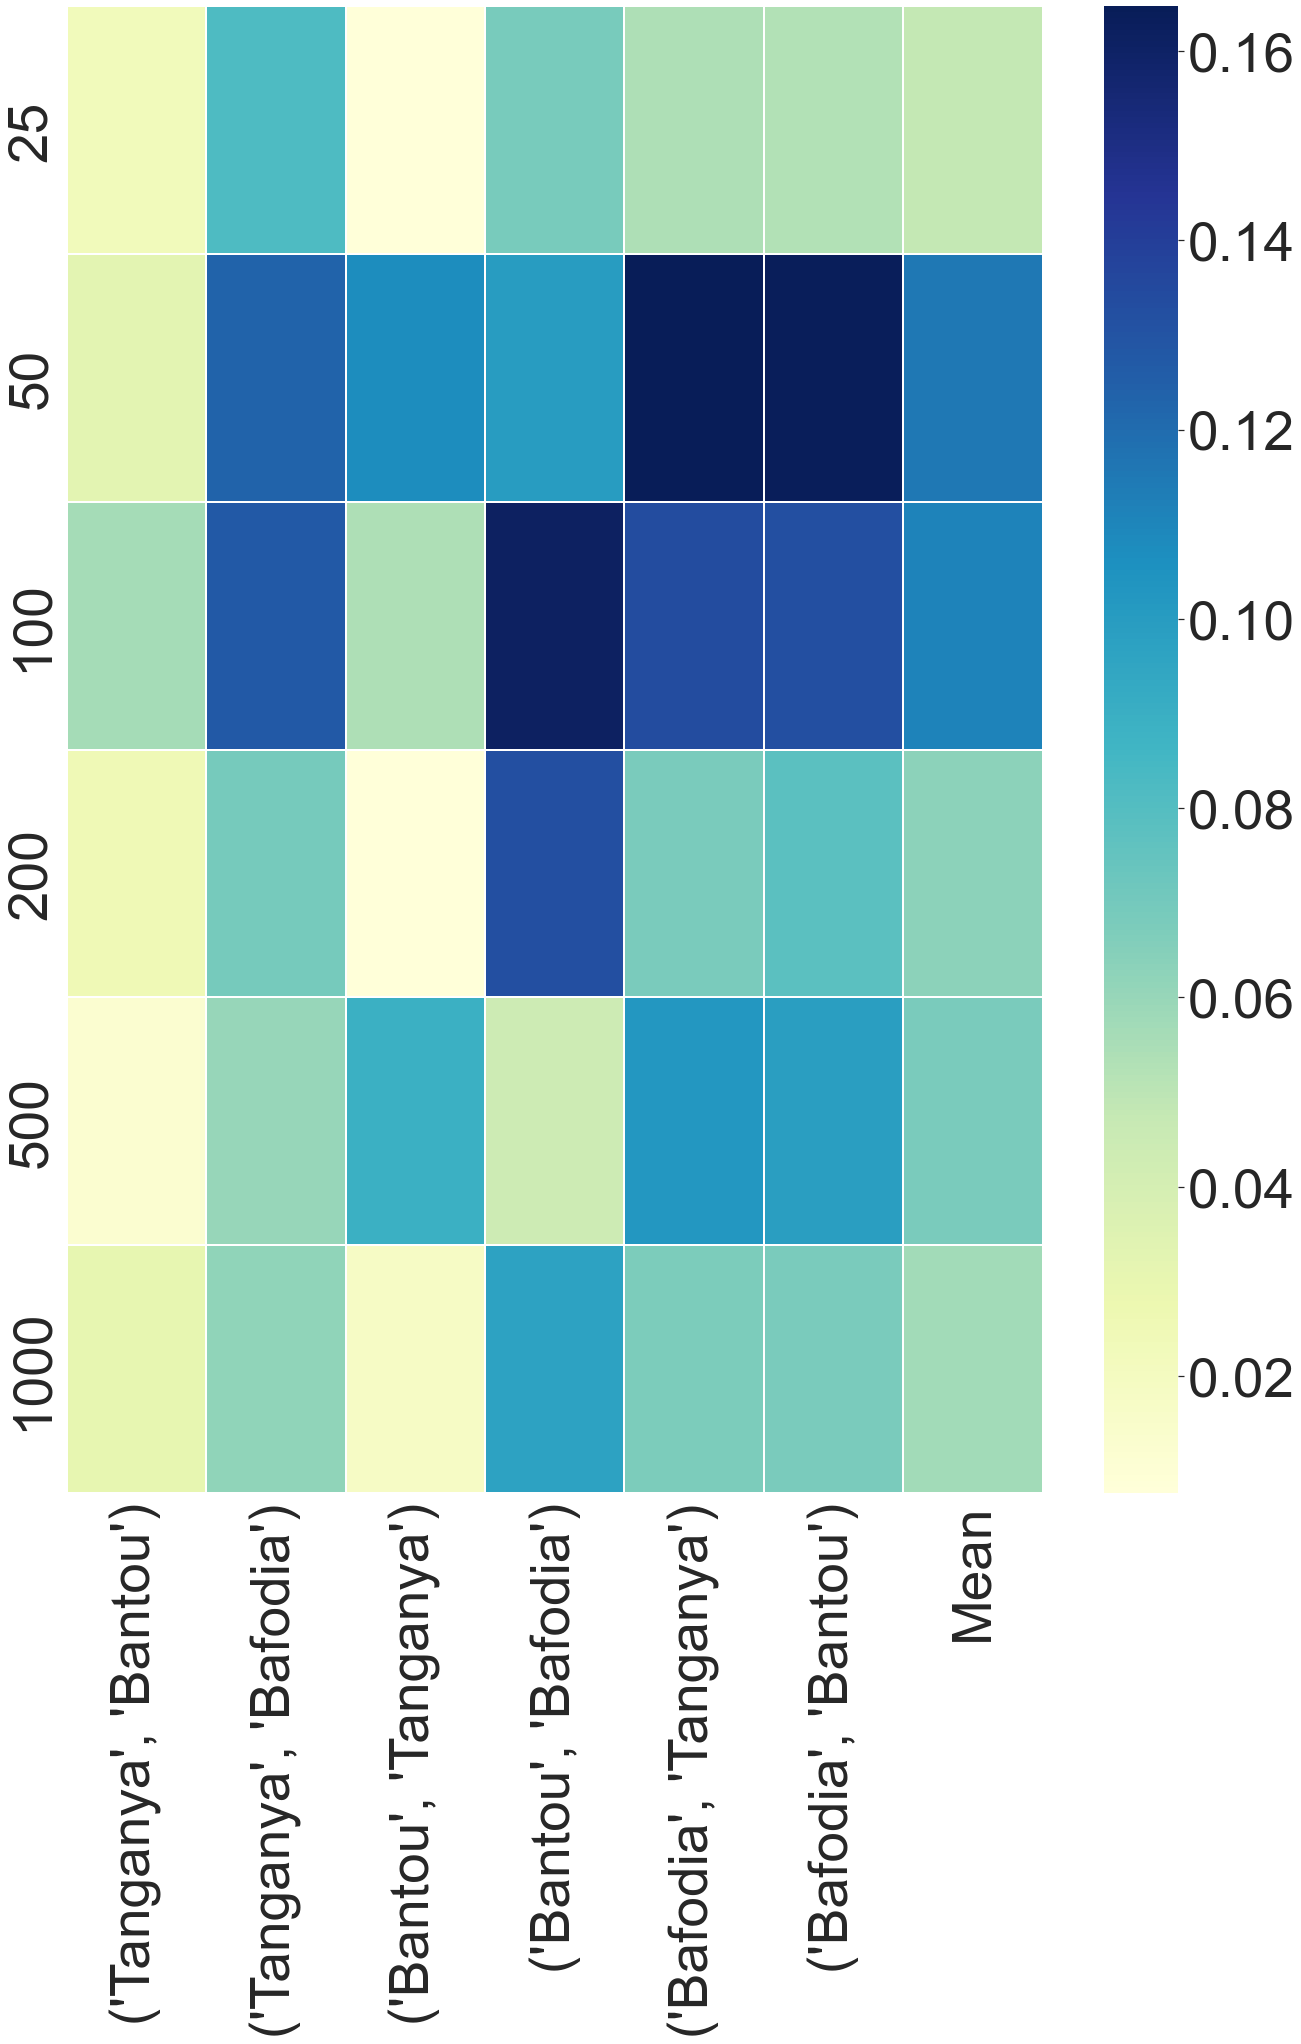

In [249]:
feature_dict = {}
for radius in [25,50,100,200,500,1000]:
    feature_set = [x for x in lc_features if str(radius) in x]
    feature_dict[str(radius)] = feature_set

plot_dat = pd.DataFrame()
for feature_i in feature_dict.keys():    
    ## Aggregate
    focal_features = feature_dict[feature_i]
    agg_pdat = pdat.loc[focal_features,:].sum(axis = 0).to_frame()
    agg_pdat.columns = [feature_i]
    plot_dat = pd.concat((plot_dat, agg_pdat), axis = 1)

plot_dat.loc[:,plot_dat.columns!='Mean'].mean(axis = 1)
fig, ax = plt.subplots(figsize=(20,30))

sns.set(font_scale=5)

sns.heatmap(plot_dat.transpose(), cmap ='YlGnBu', linewidths = 0.30, annot = False, ax = ax)
plt.tight_layout()

plt.savefig('Figures_agg/heatmap_lc_radius.png')

In [250]:
feature_names

['Frac_bare.25',
 'Frac_bare.50',
 'Frac_bare.100',
 'Frac_bare.200',
 'Frac_bare.500',
 'Frac_bare.1000',
 'Frac_grass.25',
 'Frac_grass.50',
 'Frac_grass.100',
 'Frac_grass.200',
 'Frac_grass.500',
 'Frac_grass.1000',
 'Frac_tree.25',
 'Frac_tree.50',
 'Frac_tree.100',
 'Frac_tree.200',
 'Frac_tree.500',
 'Frac_tree.1000',
 'Frac_burn.25',
 'Frac_burn.50',
 'Frac_burn.100',
 'Frac_burn.200',
 'Frac_burn.500',
 'Frac_burn.1000',
 'Frac_rice.25',
 'Frac_rice.50',
 'Frac_rice.100',
 'Frac_rice.200',
 'Frac_rice.500',
 'Frac_rice.1000',
 'Frac_water.25',
 'Frac_water.50',
 'Frac_water.100',
 'Frac_water.200',
 'Frac_water.500',
 'Frac_water.1000',
 'Frac_mound.25',
 'Frac_mound.50',
 'Frac_mound.100',
 'Frac_mound.200',
 'Frac_mound.500',
 'Frac_mound.1000',
 'Density_Buildings.25',
 'Density_Buildings.50',
 'Density_Buildings.100',
 'Density_Buildings.200',
 'Density_Buildings.500',
 'Density_Buildings.1000',
 'Density_Moderns.25',
 'Density_Moderns.50',
 'Density_Moderns.100',
 'Densit

## Make nice partial dependence CSV summary (plot in R)

In [251]:
store_all_pdp = pd.DataFrame()

fold_list = list(itertools.permutations(['Tanganya', 'Bantou', 'Bafodia']))
for ii in range(len(fold_list)):
    print('***')
    store_mod_pdp = pd.DataFrame()
    train_site, val_site, test_site = fold_list[ii]

    X_trainval, y_trainval, W_trainval, trainval_dat, test_dat = get_trainval_data(dataset = agg_data, 
                                                                         test_sites = [test_site], 
                                                                        response = 'TS_Mn', 
                                                                        weight = 'TotTraps')     

    train_xvals = trainval_dat.loc[trainval_dat.Site.isin([train_site]), get_var_names()]

    mask_model = (best_models.loc[:,'test_site'].isin([test_site]) & 
                  best_models.loc[:,'val_site'].isin([val_site])) 

    param_i = best_models.loc[mask_model, 'param'].values[0]
    xgb_model = xgb.XGBRegressor(objective = 'binary:logistic')
    this_model_path = 'Fitted_models/' + best_models.prefix.loc[mask_model].values[0] + '/'
    xgb_model.load_model(this_model_path + 'par_' + str(param_i) + '_fold_' + str(val_site) + '.txt')
    feature_names = get_var_names()

    for fi in range(len(feature_names)):
        print(str(ii) + '-' + feature_names[fi])
        focal_feature = feature_names[fi]
        np.random.seed(47)
        out = partial_dependence(xgb_model, train_xvals.sample(frac = 1, axis = 0), focal_feature, kind = 'average')

        avg = np.array(out['average']).flatten()[:,np.newaxis]
        val = np.array(out['values']).flatten()[:,np.newaxis]
        store_pdp = pd.DataFrame(np.concatenate((val,avg), axis = 1))
        store_pdp.columns = ['value', 'average']

        store_pdp.loc[:,'prefix'] = best_models.prefix.loc[mask_model].values[0]
        store_pdp.loc[:,'train_site'] = train_site
        store_pdp.loc[:,'val_site'] = val_site

        store_pdp.loc[:,'test_site'] = test_site
        store_pdp.loc[:,'param'] = param_i
        store_pdp.loc[:,'feature'] = focal_feature

        store_all_pdp = pd.concat((store_all_pdp, store_pdp ), axis = 0)   
        store_all_pdp.to_csv('Figures_agg/pdp_info.csv')

***
0-Frac_bare.25
0-Frac_bare.50
0-Frac_bare.100
0-Frac_bare.200
0-Frac_bare.500
0-Frac_bare.1000
0-Frac_grass.25
0-Frac_grass.50
0-Frac_grass.100
0-Frac_grass.200
0-Frac_grass.500
0-Frac_grass.1000
0-Frac_tree.25
0-Frac_tree.50
0-Frac_tree.100
0-Frac_tree.200
0-Frac_tree.500
0-Frac_tree.1000
0-Frac_burn.25
0-Frac_burn.50
0-Frac_burn.100
0-Frac_burn.200
0-Frac_burn.500
0-Frac_burn.1000
0-Frac_rice.25
0-Frac_rice.50
0-Frac_rice.100
0-Frac_rice.200
0-Frac_rice.500
0-Frac_rice.1000
0-Frac_water.25
0-Frac_water.50
0-Frac_water.100
0-Frac_water.200
0-Frac_water.500
0-Frac_water.1000
0-Frac_mound.25
0-Frac_mound.50
0-Frac_mound.100
0-Frac_mound.200
0-Frac_mound.500
0-Frac_mound.1000
0-Density_Buildings.25
0-Density_Buildings.50
0-Density_Buildings.100
0-Density_Buildings.200
0-Density_Buildings.500
0-Density_Buildings.1000
0-Density_Moderns.25
0-Density_Moderns.50
0-Density_Moderns.100
0-Density_Moderns.200
0-Density_Moderns.500
0-Density_Moderns.1000
0-Density_Traditionals.25
0-Density_Tra

4-sc_Density_Traditionals.50
4-sc_Density_Traditionals.100
4-sc_Density_Traditionals.200
4-sc_Density_Traditionals.500
4-sc_Density_Traditionals.1000
4-P1
4-P2
4-P3
4-P4
4-P5
4-P6
4-P7
4-P8
4-P9
4-P10
4-P11
4-P12
4-Night
4-House
***
5-Frac_bare.25
5-Frac_bare.50
5-Frac_bare.100
5-Frac_bare.200
5-Frac_bare.500
5-Frac_bare.1000
5-Frac_grass.25
5-Frac_grass.50
5-Frac_grass.100
5-Frac_grass.200
5-Frac_grass.500
5-Frac_grass.1000
5-Frac_tree.25
5-Frac_tree.50
5-Frac_tree.100
5-Frac_tree.200
5-Frac_tree.500
5-Frac_tree.1000
5-Frac_burn.25
5-Frac_burn.50
5-Frac_burn.100
5-Frac_burn.200
5-Frac_burn.500
5-Frac_burn.1000
5-Frac_rice.25
5-Frac_rice.50
5-Frac_rice.100
5-Frac_rice.200
5-Frac_rice.500
5-Frac_rice.1000
5-Frac_water.25
5-Frac_water.50
5-Frac_water.100
5-Frac_water.200
5-Frac_water.500
5-Frac_water.1000
5-Frac_mound.25
5-Frac_mound.50
5-Frac_mound.100
5-Frac_mound.200
5-Frac_mound.500
5-Frac_mound.1000
5-Density_Buildings.25
5-Density_Buildings.50
5-Density_Buildings.100
5-Density_Buil

## What do model predictions look like

In [252]:
## Specify the paths to images and convolutions
build_path = 'Data/Rasters/Satellite_Features/Building/'
lc_path = 'Data/Rasters/Satellite_Features/Land_cover_features/'
image_path = 'Data/Rasters/Satellite_Images/Small_Bing_Images/'
prec_data_path = 'Data/Rasters/MODIS_Precip/'
## Define building dictionaries that describe the landcover and building features
landcover_dict = {'0': 'Frac_bare', '1':'Frac_grass', '2':'Frac_tree',
                  '3':'Frac_burn', '4':'Frac_rice', '5':'Frac_cloud', '6':'Frac_water', 
                  '7':'Frac_mound'}
dens_building_dict = {'0':'Density_Moderns','1':'Density_Traditionals',
                 '2':'Density_Buildings'}
xgboost_param_names = ['eval_metric', 'nthread', 
                 'max_depth', 'subsample', 'n_estimators', 
                 'colsample_bytree', 'lambda', 'eta', 'booster',
                       'gamma'
                 ]

## Predict with 2 models

[Errno 17] File exists: 'Predictions/'
[Errno 17] File exists: 'Predictions/'
[Errno 17] File exists: 'Predictions/'


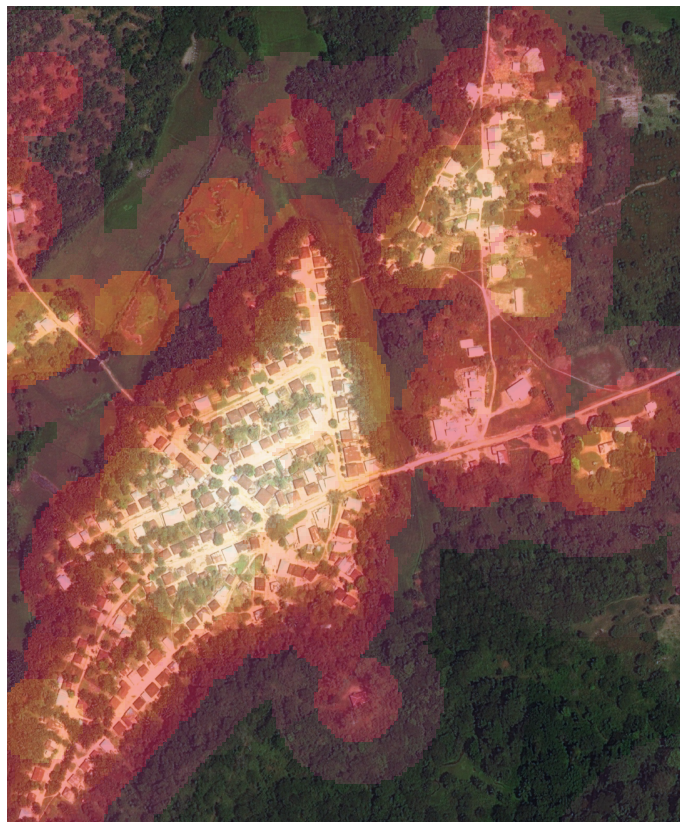

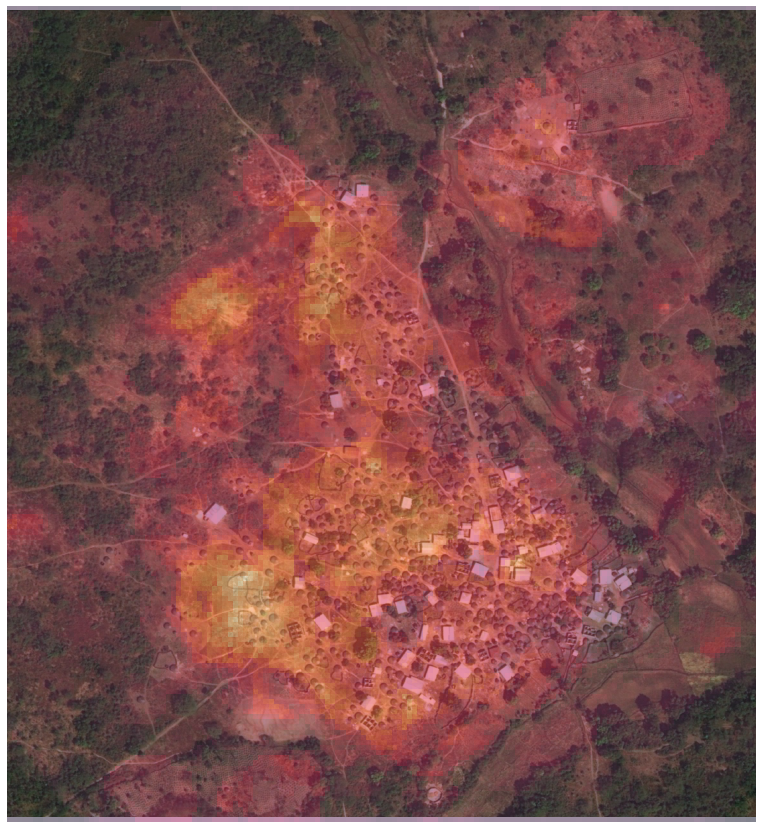

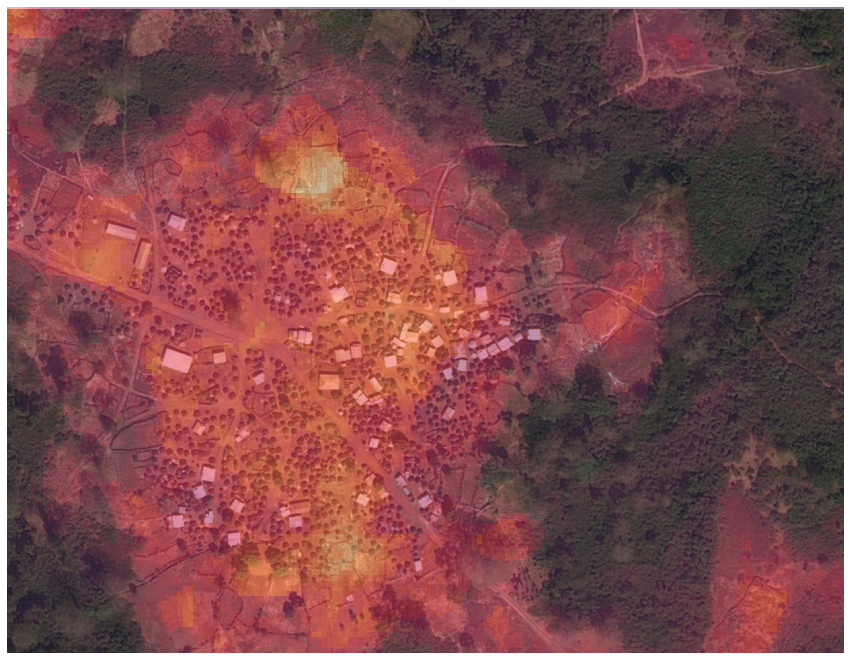

In [253]:
exec(open('Tools.py').read())

test_list = ['Bafodia', 'Tanganya', 'Bantou']
res = 5 # desired resolution of prediction in meters#dr_grid
pred_type = ['pred'] # image or pred
 
focal_year = 2019
focal_month = 6 ## dry is [12,1,2,3] in Baf
dr_model = 0
pre = ''
house = 0

for ii in range(len(test_list)):
    test_site = test_list[ii] 

    
    pos_col = 'yellow'
    if test_site != 'Bafodia':
        pos_col = 'gray'
    
    raster_site = test_site
    image_to_use = test_site

    mask_model = (best_models.loc[:,'test_site'].isin([test_site]))
    focal_rows = best_models.loc[mask_model,:]
    
    param_i = focal_rows.loc[:, 'param'].values
    n_iter = focal_rows.loc[:, 'n_iter'].values

    X_trainval, y_trainval, W_trainval, trainval_dat, test_dat = get_trainval_data(dataset = agg_data, 
                                                                        test_sites = [test_site], 
                                                                        response = 'TS_Mn', 
                                                                        weight = 'TotTraps')

    long_lat_info = agg_data[agg_data.Site.isin([test_site])]
    train_index = trainval_dat.index[trainval_dat.Site.isin([train_site])]
    val_index = []
    
    long_town = long_lat_info.Longitude
    lat_town = long_lat_info.Latitude

    ## Extract xgboost parameters
    #xgboost_params = {k: param[k] for k in (xgboost_param_names)}
    model_set = []
    for jj in focal_rows.index:
        #train_xvals = train_xvals.loc[:,get_var_names(prec_flag = focal_rows.loc[jj,'prec'])]
        
        val_site = focal_rows.loc[jj,'val_site']
        param_i = focal_rows.loc[jj,'param']
        this_prefix = focal_rows.loc[jj,'prefix']
        this_model_path = 'Fitted_models/' + this_prefix + '/'
        xgb_model = xgb.XGBRegressor(objective = 'binary:logistic')
        xgb_model.load_model(this_model_path + 'par_' + str(param_i) + '_fold_' + str(val_site) + '.txt')
        model_set.append(xgb_model)
        
    nuke_preds = []

    try: 
        os.mkdir(model_fig_path + 'mod_avg') 
    except OSError as error: 
        pass  

    fn = image_path + 'BHR_' + raster_site + '.tif'
    src = rasterio.open(fn)
    template_rast = src.read()
    xmin, ymin, xmax, ymax = src.bounds
    src.close()

    ## Limit spatial grid to trap data extent, if traps are present
    focal_traps = ((All_dat.loc[:,'Longitude'] > xmin) & (All_dat.loc[:,'Longitude'] < xmax) &
    (All_dat.loc[:,'Latitude'] > ymin) & (All_dat.loc[:,'Latitude'] < ymax))
    if np.sum(focal_traps):
        trap_dat = All_dat.loc[focal_traps,:].copy()
        long_town = trap_dat.Longitude
        lat_town = trap_dat.Latitude
        min_long, max_long = long_town.min(), long_town.max()
        min_lat, max_lat = lat_town.min(), lat_town.max()
    else:
        min_long, max_long = xmin, xmax
        min_lat, max_lat = ymin, ymax    

    ## Overlay a grid on the raster to guide where prediction takes place
    dc = res/111139
    cvecx = np.arange(min_long, max_long, dc)
    cvecy = np.arange(min_lat, max_lat, dc)

    cx = np.array([cvecx.min() - dc] + cvecx.tolist() + [cvecx.max() + dc])
    cy = np.array([cvecy.min() - dc] + cvecy.tolist() + [cvecy.max() + dc])
    cxmid = (cx[0:-1] + cx[1:])/2
    cymid = (cy[0:-1] + cy[1:])/2    

    for pred in pred_type:
        if 'pc' in pred:
            keepval = int(pred.replace('pc', ''))
            nuke_preds = ['PC' + str(x) for x in range(sig_directions) if x != keepval]    

        if pred!= 'image':
            out_prob = get_forecast(test_site = image_to_use, test_raster = raster_site, 
                                                      cxmid = cxmid, cymid = cymid,
                                                      model_set = model_set, n_iter = n_iter, 
                                                      nuke_preds = nuke_preds, var_names = get_var_names(), 
                                                      forecast_year = focal_year, 
                                                      forecast_month = focal_month, 
                                                      house = house, 
                                                      save_path = 'Predictions/',
                                                      build_path = build_path, 
                                                      lc_path = lc_path
                                                      )     
        
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(np.moveaxis(template_rast, [0], [-1]), extent = (xmin, xmax, ymin, ymax), aspect = 'equal')
        if pred!='image':
            ax.imshow(out_prob, extent = (cvecx.min()-dc, cvecx.max()+dc, cvecy.min()-dc,cvecy.max()+dc), 
                      alpha = 0.5, interpolation = None)
        ax.set_xlim(cvecx.min() - dc, cvecx.max() + dc)
        ax.set_ylim(cvecy.min() - dc, cvecy.max() + dc)
        ax.axis('off')
        plt.savefig('Figures_agg/' + 'mod_avg' + '/'+ pre + 'r' + str(res) + '_' + raster_site + '_h' + str(house) + '_' + 
                    pred + '_fm_' + str(focal_month) +'.png')

## Plot trap data

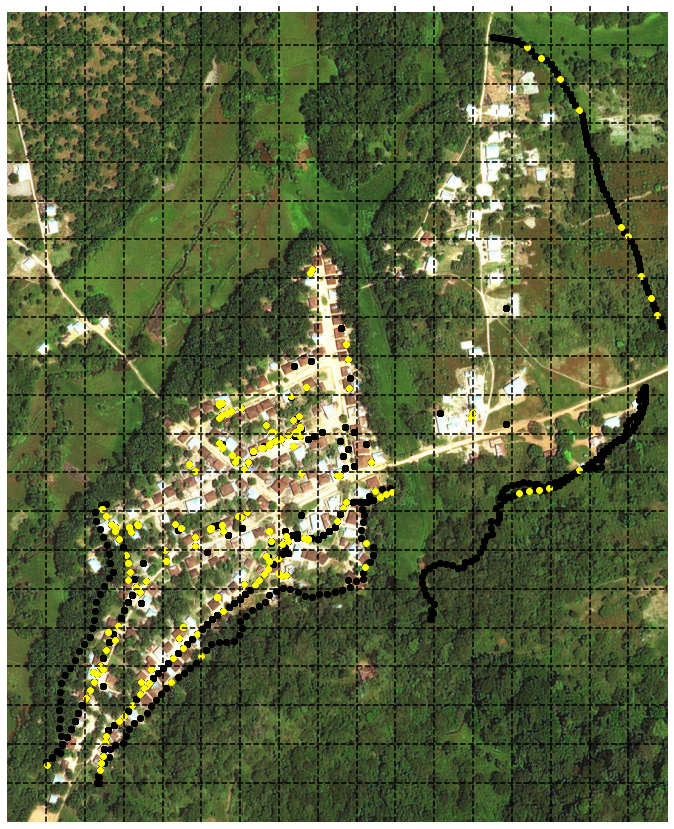

In [68]:
focal_site = 'Bafodia'
focal_raster = 'Bafodia'
suff = ''
dr_grid = 50
#visit = [1,2,3,4,5]
house = [0,1]

pos_col = 'yellow'
if focal_site != 'Bafodia':
    pos_col = 'gray'

fn = '../../RDrop/SkyLens_v3/Data/Rasters/Bing_Small_HR_Image/BHR_' + focal_raster + '.tif'
src = rasterio.open(fn)
template_rast = src.read()
xminr, yminr, xmaxr, ymaxr = src.bounds
src.close()

mask_town = ((All_dat.Site==focal_site) & (All_dat.loc[:,'ind_coords']==True) & 
            (All_dat.Longitude > xminr) & (All_dat.Longitude < xmaxr) & 
             (All_dat.Latitude > yminr) & (All_dat.Latitude < ymaxr))
trainval_dat = All_dat.loc[mask_town,:].copy()
long_town = trainval_dat.Longitude
lat_town = trainval_dat.Latitude
min_long, max_long = long_town.min(), long_town.max()
min_lat, max_lat = lat_town.min(), lat_town.max()

mask_town = mask_town & (All_dat.House.isin(house))

dc = dr_grid/111139
cvecx = np.arange(min_long, max_long, dc)
cvecy = np.arange(min_lat, max_lat, dc)
nx = len(cvecx)
ny = len(cvecy)

cx = np.array([cvecx.min() - dc] + cvecx.tolist() + [cvecx.max() + dc])
cy = np.array([cvecy.min() - dc] + cvecy.tolist() + [cvecy.max() + dc])
cxmid = (cx[0:-1] + cx[1:])/2
cymid = (cy[0:-1] + cy[1:])/2

colx = np.searchsorted(cvecx, long_town)
rowy = np.searchsorted(cvecy, lat_town)

nxy = (nx+1)*rowy + colx 

trainval_dat.loc[:,'fold1'] = nxy

mask_house = (trainval_dat.House.isin(house)) #& trainval_dat.Visit.isin(visit) 
mask_pos = mask_house & (trainval_dat.Mna==1)


totcaptures = trainval_dat.loc[mask_house,:].groupby('fold1').apply(lambda x: x.loc[x.Mna==1,:].loc[:,'Trap.weight'].sum())
tottraps = trainval_dat.loc[mask_house,:].groupby('fold1').apply(lambda x: x.loc[:,'Trap.weight'].sum())
ufolds = np.unique(nxy[mask_house])

pr_grid = np.zeros((nx+1, ny+1, 3))*np.nan

for uf in ufolds:
    rowyi = np.floor(uf/(nx + 1)).astype(int)
    colxi = int(uf % (nx + 1))
    if ((nx+1)*rowyi + colxi) != uf:
        print('error')
    #print(colx, rowy)
    pr_grid[colxi,rowyi,0] = totcaptures.loc[totcaptures.index==uf]
    pr_grid[colxi,rowyi,1] = tottraps.loc[tottraps.index==uf]
pr_grid = np.flip(np.moveaxis(pr_grid,0,1),0)
pr_grid[:,:,2] = pr_grid[:,:,0] / (pr_grid[:,:,1])

max_value = np.nanmax(pr_grid[:,:,2])

ji = dc/10
jix = 0*ji*np.random.random(size = trainval_dat.shape[0])
jiy = 0*ji*np.random.random(size = trainval_dat.shape[0])

trainval_dat.Longitude = trainval_dat.Longitude + jix
trainval_dat.Latitude = trainval_dat.Latitude + jiy

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np.moveaxis(template_rast, [0], [-1]), extent = (xminr, xmaxr, yminr, ymaxr), aspect = 'equal', 
         vmin = 0, vmax = max_value)
ax.scatter(trainval_dat.Longitude[mask_house], trainval_dat.Latitude[mask_house], c = 'black')
ax.scatter(trainval_dat.Longitude[mask_pos], trainval_dat.Latitude[mask_pos], c = pos_col)
ax.vlines(x = cvecx, ymin = 0, ymax = 15, colors = 'black', linestyles = 'dashed')
ax.hlines(y = cvecy, xmin = -15, xmax = 18, colors = 'black', linestyles = 'dashed')
ax.set_xlim(cvecx.min() - dc, cvecx.max() + dc)
ax.set_ylim(cvecy.min() - dc, cvecy.max() + dc)
#ax.imshow(pr_grid[:,:,2], extent = (cvecx.min()-dc, cvecx.max()+dc, cvecy.min()-dc, cvecy.max()+dc), alpha = 0.7, 
#         vmin = 0, vmax = max_value)
##fig
ax.grid(None)
ax.axis('off')

if focal_site != focal_raster:
    suff = focal_raster 
plt.savefig('Figures_agg/' + focal_site + suff +  '_r' + str(dr_grid) + '_h' + ''.join([str(x) for x in house]) +  '.png')

## Evaluate the effect of rainfall predictors

In [254]:
rain_data = pd.read_csv('Data/Rainfall_lag_data/supp_data.csv')
site_preds = agg_data.groupby(['Site', 'House']).apply(lambda x: x.loc[:,get_var_names(prec_flag = False, night_flag = False)].mean(axis = 0))
site_preds.pop('House')
site_preds.reset_index(inplace = True)
site_preds.loc[:,'Night'] = 1
site_preds = site_preds.merge(rain_data, left_on = 'Site', right_on = 'Site')
#site_preds.loc[:,get_var_names(prec_flag = False, night_flag = False, house_flag = False)] = np.nan

## Get model predictions on train site

In [255]:
house_set = [1,2] #which traps:  0 ~ all, 1~ just house, 2~just outside
rem_preds = []
site_list = ['Tanganya', 'Bantou', 'Bafodia']
pre = ''

store_all_stats = pd.DataFrame()

for ii in range(len(site_list)):
    train_site = test_list[ii]
    
    val_sites = [x for x in site_list if x != train_site]
    
    for ii in range(len(val_sites)):

        val_site = val_sites[ii]

        for house_num in house_set:
            house_list = [0,1]
            if house_num == 1:
                house_list = [1]
            elif house_num==2:
                house_list = [0]

            ## Assign grid ID's to data
            mask_data = ((site_preds.Site==train_site) & 
                         (site_preds.House.isin(house_list)))

            train_dat = site_preds.loc[mask_data,:].copy()                

            summ_stats = train_dat.copy()

            ## Apply model
            result_list = []

            wi_row = (best_models.train_site == train_site) & (best_models.val_site == val_site)

            best_rows = best_models.loc[wi_row,:]

            ## Loop through and apply models
            for idx in best_rows.index:
                param_i = best_rows.param.loc[idx]
                n_iter = int(best_rows.n_iter.loc[idx])
                focal_model = xgb.XGBRegressor(objective = 'reg:logistic')
                this_model_path = 'Fitted_models/' + best_rows.prefix.loc[idx] + '/'
                focal_model.load_model(this_model_path + 'par_' + str(param_i) + '_fold_' + str(val_site) + '.txt')

                train_dat_cp = train_dat.loc[:,get_var_names(prec_flag = best_rows.loc[idx,'prec'])].copy()

                rem_preds = [x for x in rem_preds if x in train_dat_cp.columns]
                train_dat_cp.loc[:,rem_preds] = np.nan
                result = focal_model.predict(train_dat_cp, iteration_range = (0,n_iter))
                result = result[:,np.newaxis]
                summ_stats.loc[:,'pred'] = result
                summ_stats.loc[:,'train_site'] = train_site
                summ_stats.loc[:,'val_site'] = val_site                        
                summ_stats.loc[:,'house_num'] = house_num
                summ_stats.loc[:,'test_site'] = [x for x in site_list if (x!=train_site) and (x!=val_site)][0]
                summ_stats.loc[:,'Model_Type'] = model_type
            summ_stats.reset_index(drop = False, inplace = True)

            store_all_stats = pd.concat((store_all_stats, summ_stats), ignore_index = True)
store_all_stats.to_csv('Figures_agg/' + 'rainfall_preds_train' + pre + '.csv')
    

## Same as above, but apply models to test site

In [258]:
house_set = [1,2] #which traps:  0 ~ all, 1~ just house, 2~just outside
rem_preds = []
site_list = ['Tanganya', 'Bantou', 'Bafodia']
pre = ''

store_all_stats = pd.DataFrame()

for ii in range(len(site_list)):
    
    train_site = site_list[ii]
    
    test_sites = [x for x in site_list if x != train_site]    
    
    for ii in range(len(test_sites)):

        test_site = test_sites[ii]
        val_site = [x for x in site_list if (x != train_site) and (x !=test_site)][0]
        
        for house_num in house_set:
            house_list = [0,1]
            if house_num == 1:
                house_list = [1]
            elif house_num==2:
                house_list = [0]

            ## Assign grid ID's to data
            mask_data = ((site_preds.Site==test_site) & 
                         (site_preds.House.isin(house_list)))

            test_dat = site_preds.loc[mask_data,:].copy()                

            summ_stats = test_dat.copy()

            ## Apply model
            result_list = []
            wi_row = (best_models.train_site == train_site) & (best_models.test_site == test_site)

            best_rows = best_models.loc[wi_row,:]
            
            ## Loop through and apply models
            for idx in best_rows.index:
                param_i = best_rows.param.loc[idx]
                n_iter = int(best_rows.n_iter.loc[idx])
                focal_model = xgb.XGBRegressor(objective = 'reg:logistic')
                this_model_path = 'Fitted_models/' + best_rows.prefix.loc[idx] + '/'
                focal_model.load_model(this_model_path + 'par_' + str(param_i) + '_fold_' + str(val_site) + '.txt')

                test_dat_cp = test_dat.loc[:,get_var_names(prec_flag = best_rows.loc[idx,'prec'])].copy()

                rem_preds = [x for x in rem_preds if x in test_dat_cp.columns]
                test_dat_cp.loc[:,rem_preds] = np.nan
                result = focal_model.predict(test_dat_cp, iteration_range = (0,n_iter))
                summ_stats.loc[:,'pred'] = result
                summ_stats.loc[:,'train_site'] = train_site
                summ_stats.loc[:,'val_site'] = val_site                        
                summ_stats.loc[:,'house_num'] = house_num
                summ_stats.loc[:,'test_site'] = test_site                   
                summ_stats.loc[:,'Model_Type'] = model_type
            summ_stats.reset_index(drop = False, inplace = True)

            store_all_stats = pd.concat((store_all_stats, summ_stats), ignore_index = True)
store_all_stats.to_csv('Figures_agg_scaled/' + 'rainfall_preds_test' + pre + '.csv')
    

In [256]:
best_models

Unnamed: 0  param train_site  val_site  n_iter  train_loss0  \
25908       25908    332    Bafodia    Bantou     650     0.062057   
37068       37068    475    Bafodia  Tanganya     950     0.058140   
5824         5824     74     Bantou   Bafodia     700     0.029830   
5413         5413     69     Bantou  Tanganya    1600     0.021967   
3873         3873     49   Tanganya   Bafodia     650     0.028438   
31660       31660    405   Tanganya    Bantou    1600     0.021848   

       train_loss1  train_loss2  train_loss3  train_loss4  val_loss0  \
25908     0.059102     0.061429     0.058332     0.058162   0.173145   
37068     0.054321     0.056118     0.053281     0.052867   0.170401   
5824      0.030709     0.030092     0.030691     0.030829   0.108341   
5413      0.022117     0.021772     0.022099     0.022193   0.032574   
3873      0.028490     0.028366     0.028435     0.028293   0.107186   
31660     0.021844     0.021995     0.021889     0.021830   0.029567   

       val_loss1  val_loss2  val_loss3  val_loss4  test_loss0  test_loss1  \
25908   0.174148   0.174145   0.173460   0.174368    0.134859    0.135994   
37068   0.172778   0.172974   0.171736   0.173228    0.196244    0.199088   
5824    0.109391   0.109637   0.108617   0.107843    0.035969    0.035977   
5413    0.032269   0.032240   0.032170   0.032460    0.113502    0.114724   
3873    0.108601   0.108465   0.107504   0.106948    0.042798    0.043177   
31660   0.029867   0.029644   0.029854   0.029887    0.120348    0.121629   

       test_loss2  test_loss3  test_loss4 booster  colsample_bytree  dr   eta  \
25908    0.136420    0.136158    0.136455  gbtree               0.2   0  0.01   
37068    0.198266    0.198439    0.198655  gbtree               0.3   0  0.01   
5824     0.036106    0.036225    0.035872  gbtree               0.3   0  0.01   
5413     0.114975    0.113613    0.113499  gbtree               0.2   0  0.01   
3873     0.043143    0.043004    0.043156  gbtree               0.2   0  0.01   
31660    0.122048    0.120327    0.120194  gbtree               0.2   0  0.01   

      eval_metric  gamma  lambda  max_depth  n_estimators  nthread  prec  \
25908        rmse    0.1       0          4          2000        2  True   
37068        rmse    0.1       0          4          2000        2  True   
5824         rmse    0.0       0          1          2000        2  True   
5413         rmse    0.0       0          1          2000        2  True   
3873         rmse    0.0       0          1          2000        2  True   
31660        rmse    2.0       0          4          2000        2  True   

       subsample test_site  train_loss  sdtrain_loss  val_loss  sdval_loss  \
25908      0.250  Tanganya    0.060862      0.001557  0.173813    0.000578   
37068      0.250    Bantou    0.056193      0.001910  0.172051    0.001432   
5824       0.001  Tanganya    0.030210      0.000451  0.109123    0.000688   
5413       0.500   Bafodia    0.021952      0.000173  0.032361    0.000185   
3873       0.001    Bantou    0.028431      0.000062  0.108084    0.000780   
31660      0.500   Bafodia    0.021896      0.000086  0.029693    0.000156   

       test_loss  sdtest_loss   type                                 prefix  
25908   0.135758     0.000807  gamma  Fit_all_scaled_multigrid1_gamma_new50  
37068   0.197866     0.001463  gamma  Fit_all_scaled_multigrid1_gamma_new50  
5824    0.036017     0.000077    md1    Fit_all_scaled_multigrid1_md1_new50  
5413    0.114400     0.000788    md1    Fit_all_scaled_multigrid1_md1_new50  
3873    0.043039     0.000210    md1    Fit_all_scaled_multigrid1_md1_new50  
31660   0.121341     0.000886  gamma  Fit_all_scaled_multigrid1_gamma_new50

In [257]:
xgb_model.objective

'reg:squarederror'